# Lending Club智能投资机器人

In [13]:
# standard import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick import features
import IPython.display

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

plt.style.available
style='ggplot'
sns.set_style('whitegrid')

## 1. 项目背景

Lending Club作为P2P模式的始祖，发展跌宕起伏。本项目通过lending club公开数据，选取多个feature预测贷款人的坏账情况，为借款人提供信息。



## 2. 数据集介绍

In [5]:
# 字段介绍

dictionary=pd.read_excel('dictionanry.xlsx')
IPython.display.HTML(dictionary[['Variable','英文释义']].to_html())

,Variable,英文释义
0,loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
1,funded_amnt,The total amount committed to that loan at that point in time.
2,funded_amnt_inv,The total amount committed by investors for that loan at that point in time.
3,term,The number of payments on the loan. Values are in months and can be either 36 or 60.
4,int_rate,Interest Rate on the loan
5,installment,The monthly payment owed by the borrower if the loan originates.
6,grade,LC assigned loan grade
7,sub_grade,LC assigned loan subgrade
8,emp_title,The job title supplied by the Borrower when applying for the loan.*
9,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.


## 3. 数据初步准备

In [50]:
# 数据导入
df=pd.read_csv('accepted_2007_to_2018Q4.csv')

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [52]:
# 初步查看数据情况
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
len(df)

2260701

In [54]:
# 查看feature
df.columns.to_list()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

### 3.1 数据初筛 & 数据清洗

In [55]:
df.term.value_counts()

 36 months    1609754
 60 months     650914
Name: term, dtype: int64

In [56]:
to_drop=[]

In [57]:
# The number of payments on the loan. Values are in months and can be either 36 or 60.
# 本项目只选取term为36的

df.term.values

array([' 36 months', ' 36 months', ' 60 months', ..., ' 60 months', nan,
       nan], dtype=object)

In [58]:
# 列中有许多空格，可以预见dataframe中string类别的列将会有许多空格，在此先去掉
df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
df['term'].values

array(['36 months', '36 months', '60 months', ..., '60 months', nan, nan],
      dtype=object)

In [59]:
# 选取term为36月的
df=df[df['term']=='36 months']
df.term.value_counts()

36 months    1609754
Name: term, dtype: int64

In [60]:
# 都是相同值，对模型将没有贡献，所以drop掉
to_drop.append('term')

In [61]:
to_drop

['term']

In [62]:
df.loan_status.value_counts()

Fully Paid                                             857491
Current                                                566695
Charged Off                                            163252
Late (31-120 days)                                      12474
In Grace Period                                          4834
Late (16-30 days)                                        2545
Does not meet the credit policy. Status:Fully Paid       1789
Does not meet the credit policy. Status:Charged Off       649
Default                                                    25
Name: loan_status, dtype: int64

In [63]:
# loan_status:Current status of the loan
# 将借贷状态分为fully paid和charged off
# charged off为本项目要预测的"positive case" 设为1

df=df.query("loan_status == 'Fully Paid' or loan_status == 'Charged Off' ")
df['loan_status'] = df['loan_status'].map({"Charged Off": 1, "Fully Paid": 0})
#df.loan_status.value_counts().plot.bar();

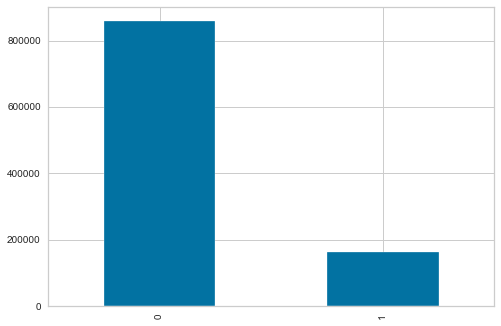

In [64]:
df['loan_status'].value_counts().plot.bar();

In [70]:
# issue_d The month which the loan was funded
# 因为文中为36term，数据截止到2018年，所以项目只选取2015年数据，简化模型
#issued=list(df['issue_d'].unique())
#issued

In [66]:
df['issue_d']=pd.to_datetime(df['issue_d'])
df['issue_d']=df['issue_d'].dt.strftime('%m-%Y')

In [67]:
df=df[(df['issue_d'].apply(lambda x:int(x[3:])))==2015]

In [69]:
len(df)

283026

In [71]:
df['issue_d'].unique()

array(['12-2015', '11-2015', '10-2015', '09-2015', '08-2015', '07-2015',
       '06-2015', '05-2015', '04-2015', '03-2015', '02-2015', '01-2015'],
      dtype=object)

In [72]:
issued=list(df['issue_d'].unique())
issued

['12-2015',
 '11-2015',
 '10-2015',
 '09-2015',
 '08-2015',
 '07-2015',
 '06-2015',
 '05-2015',
 '04-2015',
 '03-2015',
 '02-2015',
 '01-2015']

In [73]:
# 选取1-9月作为训练集，10-12月作为测试集，更考验模型的prediction power
df['train_flag']=df['issue_d'].apply(lambda x:0 if x in issued[:3] else 1)

df['train_flag'].value_counts()

1    194357
0     88669
Name: train_flag, dtype: int64

In [74]:
to_drop.append('issue_d')

In [75]:
to_drop

['term', 'issue_d']

### 3.2 查看缺失情况

In [76]:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283026 entries, 0 to 421094
Data columns (total 152 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          2244 non-null    object 
 1   member_id                                   0 non-null       float64
 2   loan_amnt                                   283026 non-null  float64
 3   funded_amnt                                 283026 non-null  float64
 4   funded_amnt_inv                             283026 non-null  float64
 5   term                                        283026 non-null  object 
 6   int_rate                                    283026 non-null  float64
 7   installment                                 283026 non-null  float64
 8   grade                                       283026 non-null  object 
 9   sub_grade                                   283026 non-null  object 


In [77]:
df.shape

(283026, 152)

In [78]:
# drop all null columns
df.dropna(how='all',axis=1,inplace=True)

In [79]:
# drop all null rows
df.dropna(how='all',axis=0,inplace=True)

In [80]:
# 共15个完全缺失的feature
df.shape

(283026, 137)

In [81]:
# 没有完全重复的两条数据
df=df.drop_duplicates()

In [82]:
df.shape

(283026, 137)

In [84]:
(df.isnull().sum().sort_values(ascending=False)/len(df)).head(50)

desc                                          0.999862
dti_joint                                     0.999159
verification_status_joint                     0.999156
annual_inc_joint                              0.999156
orig_projected_additional_accrued_interest    0.996428
deferral_term                                 0.995615
hardship_end_date                             0.995615
payment_plan_start_date                       0.995615
hardship_length                               0.995615
hardship_dpd                                  0.995615
hardship_loan_status                          0.995615
hardship_last_payment_amount                  0.995615
hardship_payoff_balance_amount                0.995615
hardship_amount                               0.995615
hardship_status                               0.995615
hardship_reason                               0.995615
hardship_type                                 0.995615
hardship_start_date                           0.995615
id        

### 3.3 分类特征变量探查 & 初筛

In [88]:
cols=df.columns.values
num_feature=[]
ob_feature=[]
for col in cols:
    if df[col].dtype == 'object':
            ob_feature.append(col)
    else:
            num_feature.append(col)
    

In [86]:
num_feature

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'loan_status',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal

In [89]:
ob_feature

['id',
 'term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'disbursement_method',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date']

In [90]:
# id没啥用，drop掉
i=0
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

id
280782


38191572    1
37117621    1
38271149    1
37927613    1
582543      1
           ..
37938605    1
38301605    1
38281361    1
37148002    1
36733384    1
Name: id, Length: 2244, dtype: int64

In [91]:
to_drop.append('id')

In [92]:
to_drop

['term', 'issue_d', 'id']

In [93]:
i=1
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

term
0


36 months    283026
Name: term, dtype: int64

In [94]:
# grade,定序变量，ordinal encoding
i=2
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

grade
0


B    91725
C    77423
A    70118
D    32711
E     9443
F     1361
G      245
Name: grade, dtype: int64

In [96]:
ordinal_feature=[]

In [97]:
ordinal_feature.append('grade')

In [98]:
ordinal_feature

['grade']

In [99]:
# subgrade同理 ordinal encoding
i=3
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

sub_grade
0


A5    20408
B5    19119
C1    18748
B3    18513
B2    18278
B4    18069
B1    17746
C2    17542
C3    15601
A4    14924
C4    13819
A1    12372
C5    11713
A2    11526
A3    10888
D1     9642
D2     7384
D3     6447
D4     5016
D5     4222
E1     3185
E2     2396
E3     1867
E4     1184
E5      811
F1      514
F2      320
F3      235
F4      158
F5      134
G1       95
G2       80
G3       41
G4       23
G5        6
Name: sub_grade, dtype: int64

In [100]:
ordinal_feature.append('sub_grade')

In [101]:
ordinal_feature

['grade', 'sub_grade']

In [102]:
# emp_title变量很多，使用count encoding
i=4
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

emp_title
19009


Teacher                             5500
Manager                             4632
Owner                               2899
Registered Nurse                    2229
RN                                  2172
                                    ... 
Intelligence officer                   1
Registered Nurse-Clinical Leader       1
asst. plant manager                    1
WIA Assistant                          1
e-commerce & it director               1
Name: emp_title, Length: 81641, dtype: int64

In [103]:
frequency_feature=[]

In [104]:
frequency_feature.append('emp_title')

In [105]:
frequency_feature

['emp_title']

In [106]:
# emp_length需要特殊处理，label encoding
i=5
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

emp_length
18960


10+ years    89647
2 years      25879
< 1 year     24077
3 years      23094
1 year       19233
5 years      16884
4 years      16745
8 years      14265
7 years      12156
6 years      11178
9 years      10908
Name: emp_length, dtype: int64

In [107]:
ordinal_feature.append('emp_length')

In [108]:
ordinal_feature

['grade', 'sub_grade', 'emp_length']

In [109]:
# one hot encoding
i=6
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

home_ownership
0


MORTGAGE    129762
RENT        121463
OWN          31800
ANY              1
Name: home_ownership, dtype: int64

In [110]:
onehot_feature=[]
onehot_feature.append('home_ownership')
onehot_feature

['home_ownership']

In [111]:
# 同理 one hot encoding
i=7
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

verification_status
0


Source Verified    119216
Not Verified        83226
Verified            80584
Name: verification_status, dtype: int64

In [112]:
onehot_feature.append('verification_status')
onehot_feature

['home_ownership', 'verification_status']

In [113]:
i=8
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

issue_d
0


10-2015    33186
07-2015    30864
12-2015    30241
11-2015    25242
08-2015    23938
01-2015    23631
04-2015    23619
05-2015    21539
06-2015    19064
09-2015    18765
03-2015    16914
02-2015    16023
Name: issue_d, dtype: int64

In [115]:
# 只有一个量 直接drop掉
i=9
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

pymnt_plan
0


n    283026
Name: pymnt_plan, dtype: int64

In [116]:
to_drop.append('pymnt_plan')

In [117]:
to_drop

['term', 'issue_d', 'id', 'pymnt_plan']

In [118]:
# 没用 drop
i=10
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

url
0


https://lendingclub.com/browse/loanDetail.action?loan_id=57264682    1
https://lendingclub.com/browse/loanDetail.action?loan_id=38526907    1
https://lendingclub.com/browse/loanDetail.action?loan_id=60784605    1
https://lendingclub.com/browse/loanDetail.action?loan_id=65837384    1
https://lendingclub.com/browse/loanDetail.action?loan_id=63247225    1
                                                                    ..
https://lendingclub.com/browse/loanDetail.action?loan_id=57814761    1
https://lendingclub.com/browse/loanDetail.action?loan_id=62439253    1
https://lendingclub.com/browse/loanDetail.action?loan_id=54524045    1
https://lendingclub.com/browse/loanDetail.action?loan_id=50890337    1
https://lendingclub.com/browse/loanDetail.action?loan_id=38639078    1
Name: url, Length: 283026, dtype: int64

In [119]:
to_drop.append('url')
to_drop

['term', 'issue_d', 'id', 'pymnt_plan', 'url']

In [120]:
# 可以使用NLP的方法 这里直接drop吧还是
i=11
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

desc
282987


In [121]:
to_drop.append('desc')
to_drop

['term', 'issue_d', 'id', 'pymnt_plan', 'url', 'desc']

In [122]:
# one hot encoding
i=12
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

purpose
0


debt_consolidation    160983
credit_card            70650
home_improvement       17160
other                  15227
major_purchase          5342
medical                 3146
car                     2768
small_business          2425
vacation                2071
moving                  2061
house                   1004
renewable_energy         185
wedding                    3
educational                1
Name: purpose, dtype: int64

In [123]:
onehot_feature.append('purpose')
onehot_feature

['home_ownership', 'verification_status', 'purpose']

In [124]:
# title frequency encoding
i=13
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

title
87


Debt consolidation                         160929
Credit card refinancing                     70668
Home improvement                            17140
Other                                       15212
Major purchase                               5329
Medical expenses                             3136
Car financing                                2773
Business                                     2421
Vacation                                     2067
Moving and relocation                        2065
Home buying                                  1004
Green loan                                    185
odymeds                                         1
Learning and training                           1
Paying off higher interest cards & auto         1
new kitchen for momma!                          1
Trying to come back to reality!                 1
Prescription Drug and Medical Costs             1
New Baby and New House (CC Consolidate)         1
Pay off Lowes Card                              1


In [125]:
frequency_feature.append('title')

In [128]:
frequency_feature

['emp_title', 'title']

In [131]:
# zipcode frequency encoding
i=14
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

zip_code
0


945xx    3150
112xx    3085
750xx    2961
606xx    2929
300xx    2720
         ... 
849xx       1
204xx       1
203xx       1
507xx       1
929xx       1
Name: zip_code, Length: 901, dtype: int64

In [132]:
frequency_feature.append('zip_code')
frequency_feature

['emp_title', 'title', 'zip_code']

In [133]:
# addr_state frequency encoding
i=15
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

addr_state
0


CA    41377
TX    23530
NY    23386
FL    20374
IL    11609
NJ    10088
PA     9505
GA     9383
OH     9168
MI     7737
VA     7659
NC     7644
AZ     6652
MD     6467
MA     6370
WA     6017
CO     5967
MN     5094
IN     4597
TN     4428
MO     4378
NV     4250
CT     4221
WI     3827
OR     3399
AL     3373
LA     3294
SC     3182
KY     2607
OK     2596
KS     2413
AR     2037
UT     1802
MS     1718
NM     1588
HI     1401
NH     1384
RI     1228
WV     1182
DE      800
MT      796
NE      754
DC      716
AK      650
WY      595
VT      588
SD      550
ME      334
ND      311
Name: addr_state, dtype: int64

In [134]:
frequency_feature.append('addr_state')
frequency_feature

['emp_title', 'title', 'zip_code', 'addr_state']

In [135]:
# 需要特殊处理
i=16
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

earliest_cr_line
0


Aug-2002    2084
Aug-2001    2065
Sep-2003    2012
Sep-2002    1958
Sep-2004    1950
            ... 
Jun-1955       1
Jul-1951       1
May-1961       1
Aug-1951       1
Mar-1958       1
Name: earliest_cr_line, Length: 656, dtype: int64

In [136]:
mannual_handle_feature=[]

In [137]:
mannual_handle_feature.append('earliest_cr_line')
mannual_handle_feature

['earliest_cr_line']

In [138]:
# obviously one hot encoding
i=17
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

initial_list_status
0


w    166168
f    116858
Name: initial_list_status, dtype: int64

In [139]:
onehot_feature.append('initial_list_status')
onehot_feature

['home_ownership', 'verification_status', 'purpose', 'initial_list_status']

In [140]:
i=18
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

last_pymnt_d
200


Mar-2018    11789
Aug-2018    10816
Jan-2018    10768
Feb-2018    10606
Jun-2018    10187
Jul-2018    10177
May-2018     9786
Oct-2018     9709
Apr-2018     9673
Nov-2018     9178
Mar-2017     7871
Dec-2018     7761
Sep-2018     7496
Aug-2017     6796
Jun-2017     6558
May-2017     6524
Jan-2017     6398
Jul-2017     6388
Oct-2016     6257
Dec-2016     6116
Feb-2017     6098
Nov-2016     6075
Jul-2016     6016
Apr-2017     5988
Oct-2017     5974
Aug-2016     5962
Mar-2016     5870
Sep-2016     5822
Sep-2017     5591
Nov-2017     5480
Jun-2016     5475
Dec-2017     5430
May-2016     4971
Apr-2016     4940
Feb-2016     4688
Jan-2016     4217
Dec-2015     3813
Oct-2015     3192
Nov-2015     2989
Jan-2019     2749
Sep-2015     2486
Aug-2015     2091
Jul-2015     1883
Jun-2015     1305
May-2015      972
Apr-2015      721
Mar-2015      452
Feb-2019      370
Feb-2015      257
Mar-2019       69
Jan-2015       26
Name: last_pymnt_d, dtype: int64

In [141]:
df[feat].isnull().sum()/len(df)

0.000706648859115417

In [142]:
# 这个feature对模型没有分类能力，因为每一笔loan肯定有最后还款期限，这里直接drop掉
to_drop.append('last_pymnt_d')
to_drop

['term', 'issue_d', 'id', 'pymnt_plan', 'url', 'desc', 'last_pymnt_d']

In [143]:
i=19
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

last_credit_pull_d
6


Mar-2019    104234
Jul-2018     13328
Feb-2019     12548
Oct-2018     11340
Jan-2019     11082
Aug-2018     10958
Nov-2018     10590
Dec-2018     10577
Sep-2018      7644
Oct-2016      6729
May-2018      6233
Apr-2018      6010
Mar-2018      5992
Feb-2017      5367
Jan-2018      5319
Feb-2018      5303
Oct-2017      4342
Jun-2017      3493
Nov-2017      3411
Dec-2017      3328
Sep-2017      3299
Aug-2017      3258
Jul-2017      2911
Mar-2017      2836
Apr-2017      2637
Jan-2017      2485
Dec-2016      2103
May-2017      2076
Jun-2018      2025
Nov-2016      1713
Aug-2016       982
Jul-2016       970
Apr-2016       947
Mar-2016       849
Feb-2016       846
Jun-2016       806
May-2016       709
Jan-2016       606
Dec-2015       502
Nov-2015       424
Oct-2015       383
Sep-2015       373
Sep-2016       369
Aug-2015       260
Jul-2015       248
Jun-2015       199
May-2015       131
Apr-2015       105
Mar-2015        66
Feb-2015        47
Jan-2015        24
Dec-2014         3
Name: last_c

In [144]:
# 同理 drop 
to_drop.append('last_credit_pull_d')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d']

In [145]:
# obviously one hot
i=20
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

application_type
0


Individual    282787
Joint App        239
Name: application_type, dtype: int64

In [146]:
onehot_feature.append('application_type')
onehot_feature

['home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type']

In [147]:
# 只有一个值 drop掉
i=21
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

verification_status_joint
282787


Not Verified    239
Name: verification_status_joint, dtype: int64

In [148]:
to_drop.append('verification_status_joint')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint']

In [150]:
# 只有一个值 drop掉
i=22
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

hardship_flag
0


N    283026
Name: hardship_flag, dtype: int64

In [151]:
to_drop.append('hardship_flag')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag']

In [152]:
# 只有一个值 drop掉
i=23
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

hardship_type
281785


INTEREST ONLY-3 MONTHS DEFERRAL    1241
Name: hardship_type, dtype: int64

In [153]:
to_drop.append('hardship_type')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type']

In [154]:
# one hot encoding
i=24
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

hardship_reason
281785


NATURAL_DISASTER         386
EXCESSIVE_OBLIGATIONS    220
UNEMPLOYMENT             206
MEDICAL                  147
INCOME_CURTAILMENT       136
REDUCED_HOURS             81
DIVORCE                   24
FAMILY_DEATH              23
DISABILITY                18
Name: hardship_reason, dtype: int64

In [155]:
onehot_feature.append('hardship_reason')
onehot_feature

['home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type',
 'hardship_reason']

In [156]:
# one hot encoding
i=25
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

hardship_status
281785


COMPLETED    1011
BROKEN        230
Name: hardship_status, dtype: int64

In [157]:
onehot_feature.append('hardship_status')
onehot_feature

['home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type',
 'hardship_reason',
 'hardship_status']

In [158]:
i=26
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

hardship_start_date
281785


Sep-2017    368
Oct-2017    194
Jun-2017    115
May-2017    107
Nov-2017     96
Jul-2017     78
Aug-2017     70
Dec-2017     68
Jan-2018     39
Feb-2018     29
Mar-2018     17
Jun-2018     14
May-2018     11
Apr-2018     11
Jul-2018     11
Aug-2018      6
Sep-2018      4
Oct-2018      1
Feb-2017      1
Mar-2017      1
Name: hardship_start_date, dtype: int64

In [161]:
# 超高删失率，处理后效果可能不太好，这里直接drop掉
df[feat].isnull().sum()/len(df)

0.9956152438291889

In [162]:
to_drop.append('hardship_start_date')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_start_date']

In [163]:
# 同理 drop掉
i=27
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

hardship_end_date
281785


Dec-2017    281
Nov-2017    203
Jan-2018    144
Aug-2017    121
Sep-2017     99
Oct-2017     85
Feb-2018     76
Mar-2018     59
Jul-2017     47
Apr-2018     32
Jun-2018     20
May-2018     13
Aug-2018     13
Jul-2018     11
Oct-2018     10
Jun-2017     10
Sep-2018      9
Nov-2018      4
Dec-2018      2
May-2017      1
Mar-2017      1
Name: hardship_end_date, dtype: int64

In [164]:
to_drop.append('hardship_end_date')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_start_date',
 'hardship_end_date']

In [165]:
# drop
i=28
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

payment_plan_start_date
281785


Oct-2017    260
Sep-2017    258
Nov-2017    136
Jun-2017    119
Jul-2017     97
Dec-2017     85
Aug-2017     62
May-2017     60
Jan-2018     47
Feb-2018     34
Apr-2018     17
Mar-2018     15
Aug-2018     13
May-2018     12
Jul-2018     10
Jun-2018      9
Sep-2018      3
Oct-2018      2
Feb-2017      1
Mar-2017      1
Name: payment_plan_start_date, dtype: int64

In [166]:
to_drop.append('payment_plan_start_date')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date']

In [168]:
i=29
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

hardship_loan_status
281785


Late (16-30 days)     534
In Grace Period       328
Current               317
Late (31-120 days)     62
Name: hardship_loan_status, dtype: int64

In [169]:
df[feat].isnull().sum()/len(df)

0.9956152438291889

In [170]:
# 高删失率，这里直接drop
to_drop.append('hardship_loan_status')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status']

In [171]:
# 只有一个量 drop
i=30
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

disbursement_method
0


Cash    283026
Name: disbursement_method, dtype: int64

In [172]:
to_drop.append('disbursement_method')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'disbursement_method']

In [173]:
# one hot encoding
i=31
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

debt_settlement_flag
0


N    276732
Y      6294
Name: debt_settlement_flag, dtype: int64

In [174]:
onehot_feature.append('debt_settlement_flag')
onehot_feature

['home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type',
 'hardship_reason',
 'hardship_status',
 'debt_settlement_flag']

In [175]:
i=32
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

debt_settlement_flag_date
276732


Oct-2018    450
Aug-2018    409
Nov-2018    379
Jun-2018    362
Dec-2018    334
Jul-2018    322
May-2018    311
Jan-2018    310
Sep-2018    294
Feb-2019    292
Feb-2018    286
Jan-2019    277
Mar-2019    259
Mar-2018    239
Nov-2017    225
Sep-2017    209
Jun-2017    173
Dec-2017    156
Apr-2018    148
Oct-2017    139
Apr-2017    130
Jul-2017    123
Aug-2017     99
May-2017     93
Mar-2017     60
Dec-2016     48
Jan-2017     47
Feb-2017     30
Aug-2016     16
Jun-2016     15
Sep-2016     11
Apr-2016     10
Jul-2016     10
Mar-2016      7
May-2016      5
Oct-2016      4
Oct-2015      3
Jan-2016      3
Nov-2016      2
Feb-2016      2
Sep-2015      1
Dec-2015      1
Name: debt_settlement_flag_date, dtype: int64

In [176]:
df[feat].isnull().sum()/len(df)

0.9777617604036378

In [180]:
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'disbursement_method',
 'debt_settlement_flag_date']

In [178]:
i=33
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

settlement_status
276732


COMPLETE    4086
ACTIVE      1231
BROKEN       977
Name: settlement_status, dtype: int64

In [179]:
df[feat].isnull().sum()/len(df)

0.9777617604036378

In [181]:
to_drop.append('settlement_status')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'disbursement_method',
 'debt_settlement_flag_date',
 'settlement_status']

In [182]:
i=34
feat = ob_feature[i]
print(feat)
print(df[feat].isnull().sum())
df[feat].value_counts()

settlement_date
276732


Oct-2017    376
Mar-2018    375
Nov-2017    343
Jan-2018    328
Feb-2018    326
Sep-2017    318
Apr-2017    310
Dec-2017    308
Aug-2017    301
Apr-2018    291
May-2018    278
Jun-2017    256
Jun-2018    231
Jul-2017    223
Aug-2018    202
May-2017    199
Sep-2018    153
Mar-2017    148
Oct-2018    147
Jul-2018    137
Feb-2017    128
Jan-2017    125
Dec-2018     84
Dec-2016     83
Nov-2018     78
Jan-2019     78
Feb-2019     64
Nov-2016     60
Oct-2016     57
Aug-2016     47
Jun-2016     35
Sep-2016     35
Mar-2019     33
Jul-2016     27
Mar-2016     19
May-2016     18
Feb-2016     18
Apr-2016     16
Oct-2015     10
Jan-2016     10
Nov-2015      6
Dec-2015      5
Sep-2015      3
Aug-2015      2
Jun-2015      1
May-2015      1
Jul-2015      1
Name: settlement_date, dtype: int64

In [183]:
df[feat].isnull().sum()/len(df)

0.9777617604036378

In [184]:
# 高删失率 drop
to_drop.append('settlement_date')
to_drop

['term',
 'issue_d',
 'id',
 'pymnt_plan',
 'url',
 'desc',
 'last_pymnt_d',
 'last_credit_pull_d',
 'verification_status_joint',
 'hardship_flag',
 'hardship_type',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_loan_status',
 'disbursement_method',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date']

In [187]:
#i=35
#feat = ob_feature[i]
#print(feat)
#print(df[feat].isnull().sum())
#df[feat].value_counts()

In [188]:
df.drop(to_drop,axis=1,inplace=True)

In [189]:
df.shape

(283026, 118)

In [190]:
to_drop=[]

In [191]:
to_drop

[]

## 4. 进一步准备

### 4.1 数据基本情况探查 & 处理

In [192]:
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,fico_range_low,...,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,train_flag
count,283026.000000,283026.000000,283026.000000,283026.000000,283026.000000,2.830260e+05,283026.000000,283024.000000,283026.000000,283026.000000,...,1241.000000,1241.0,1241.000000,1011.000000,1241.000000,1241.000000,6294.000000,6294.000000,6294.000000,283026.000000
mean,12805.540127,12805.540127,12801.042770,11.276525,419.962161,7.452191e+04,0.148863,18.474864,0.352918,693.641715,...,57.988445,3.0,13.786463,172.583383,5419.538743,101.496994,3143.919077,47.347598,10.572450,0.686711
std,8059.993716,8059.993716,8057.619996,3.687316,265.873649,7.604828e+04,0.355954,8.884950,0.939690,30.796475,...,49.473784,0.0,9.934236,145.105541,3878.928452,127.404648,2697.760232,6.532558,7.463375,0.463832
min,1000.000000,1000.000000,900.000000,5.320000,14.010000,0.000000e+00,0.000000,0.000000,0.000000,660.000000,...,0.640000,3.0,0.000000,1.920000,55.730000,0.020000,107.000000,20.000000,0.000000,0.000000
25%,6800.000000,6800.000000,6800.000000,8.180000,219.940000,4.400000e+04,0.000000,11.950000,0.000000,670.000000,...,24.200000,3.0,0.000000,71.775000,2647.330000,26.200000,1320.232500,45.000000,5.000000,0.000000
50%,10000.000000,10000.000000,10000.000000,11.220000,341.730000,6.200000e+04,0.000000,17.870000,0.000000,685.000000,...,42.670000,3.0,15.000000,128.340000,4266.530000,58.850000,2348.285000,45.010000,10.000000,1.000000
75%,17000.000000,17000.000000,17000.000000,13.660000,560.840000,9.000000e+04,0.000000,24.560000,0.000000,710.000000,...,72.210000,3.0,23.000000,215.505000,7035.930000,125.600000,4099.727500,50.000000,15.000000,1.000000
max,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.000000e+06,1.000000,999.000000,30.000000,845.000000,...,335.180000,3.0,30.000000,964.920000,22507.180000,1247.480000,23555.340000,166.670000,65.000000,1.000000


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283026 entries, 0 to 421094
Columns: 118 entries, loan_amnt to train_flag
dtypes: float64(100), int64(2), object(16)
memory usage: 257.0+ MB


### 4.2 缺失情况探查

In [194]:
# 可以看到缺失情况还是很高
df.isnull().sum().sort_values(ascending=False).head(50)/len(df)

dti_joint                                     0.999159
annual_inc_joint                              0.999156
orig_projected_additional_accrued_interest    0.996428
hardship_last_payment_amount                  0.995615
hardship_payoff_balance_amount                0.995615
hardship_dpd                                  0.995615
hardship_length                               0.995615
hardship_amount                               0.995615
deferral_term                                 0.995615
hardship_status                               0.995615
hardship_reason                               0.995615
settlement_percentage                         0.977762
settlement_amount                             0.977762
settlement_term                               0.977762
il_util                                       0.954714
mths_since_rcnt_il                            0.949054
open_rv_24m                                   0.947411
open_acc_6m                                   0.947411
open_act_i

虽然**xgboost**,**catboost**等以树为base的继承学习方法都有很好的处理missing value的能力，在这里还是去掉删失率达到90%以上的列.

https://link.springer.com/article/10.1007/s42452-020-3128-y#:~:text=XGBoost%20is%20a%20gradient%20tree,doing%20imputation%20first%20%5B6%5D.

In [201]:
df.isnull().sum().sort_values(ascending=False).head(28)/len(df)

dti_joint                                     0.999159
annual_inc_joint                              0.999156
orig_projected_additional_accrued_interest    0.996428
hardship_last_payment_amount                  0.995615
hardship_payoff_balance_amount                0.995615
hardship_dpd                                  0.995615
hardship_length                               0.995615
hardship_amount                               0.995615
deferral_term                                 0.995615
hardship_status                               0.995615
hardship_reason                               0.995615
settlement_percentage                         0.977762
settlement_amount                             0.977762
settlement_term                               0.977762
il_util                                       0.954714
mths_since_rcnt_il                            0.949054
open_rv_24m                                   0.947411
open_acc_6m                                   0.947411
open_act_i

In [202]:
to_drop = df.isnull().sum().sort_values(ascending=False).head(28).index
to_drop

Index(['dti_joint', 'annual_inc_joint',
       'orig_projected_additional_accrued_interest',
       'hardship_last_payment_amount', 'hardship_payoff_balance_amount',
       'hardship_dpd', 'hardship_length', 'hardship_amount', 'deferral_term',
       'hardship_status', 'hardship_reason', 'settlement_percentage',
       'settlement_amount', 'settlement_term', 'il_util', 'mths_since_rcnt_il',
       'open_rv_24m', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'total_cu_tl', 'inq_fi', 'all_util', 'open_il_24m', 'total_bal_il',
       'max_bal_bc', 'inq_last_12m', 'open_rv_12m'],
      dtype='object')

In [203]:
to_drop.to_list()

['dti_joint',
 'annual_inc_joint',
 'orig_projected_additional_accrued_interest',
 'hardship_last_payment_amount',
 'hardship_payoff_balance_amount',
 'hardship_dpd',
 'hardship_length',
 'hardship_amount',
 'deferral_term',
 'hardship_status',
 'hardship_reason',
 'settlement_percentage',
 'settlement_amount',
 'settlement_term',
 'il_util',
 'mths_since_rcnt_il',
 'open_rv_24m',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'total_cu_tl',
 'inq_fi',
 'all_util',
 'open_il_24m',
 'total_bal_il',
 'max_bal_bc',
 'inq_last_12m',
 'open_rv_12m']

In [204]:
df.drop(columns=to_drop,inplace=True)
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283026 entries, 0 to 421094
Data columns (total 90 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   loan_amnt                       283026 non-null  float64
 1   funded_amnt                     283026 non-null  float64
 2   funded_amnt_inv                 283026 non-null  float64
 3   int_rate                        283026 non-null  float64
 4   installment                     283026 non-null  float64
 5   grade                           283026 non-null  object 
 6   sub_grade                       283026 non-null  object 
 7   emp_title                       264017 non-null  object 
 8   emp_length                      264066 non-null  object 
 9   home_ownership                  283026 non-null  object 
 10  annual_inc                      283026 non-null  float64
 11  verification_status             283026 non-null  object 
 12  loan_status     

In [205]:
df.shape

(283026, 90)

In [207]:
onehot_feature.remove('hardship_status')
onehot_feature.remove('hardship_reason')
onehot_feature

['home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type',
 'debt_settlement_flag']

In [212]:
to_drop=[]
to_drop

[]

In [216]:
#df.to_csv('lending_club_final_version1.csv')

## 5. 探索性数据分析

In [217]:
train_df=df[df['train_flag']==1]

In [218]:
train_df.shape

(194357, 90)

In [219]:
cat_feature=train_df.select_dtypes(include='object').columns

In [220]:
cat_feature

Index(['grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'application_type',
       'debt_settlement_flag'],
      dtype='object')

In [222]:
train_df[cat_feature].describe()

,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type,debt_settlement_flag
count,194357,194357,181830,181853,194357,194357,194357,194357,194357,194357,194357,194357,194357,194357
unique,7,35,60618,11,3,3,14,20,890,49,637,2,1,2
top,B,A5,Teacher,10+ years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,945xx,CA,Aug-2001,w,Individual,N
freq,59638,14583,3777,61154,88377,80823,112985,112959,2204,28906,1471,101350,194357,190247


/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


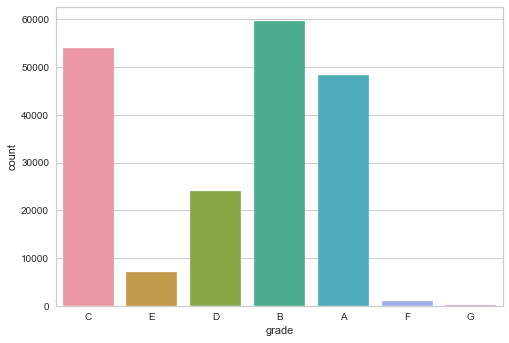

In [223]:
# 查看grade的分布,主要集中在ABC
sns.countplot(train_df['grade']);

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


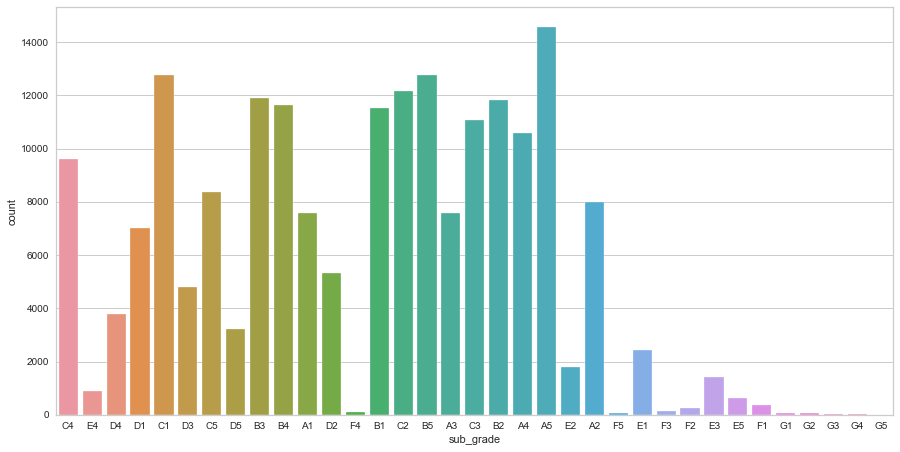

In [225]:
plt.figure(figsize=(15,7.5))
sns.countplot(train_df['sub_grade']);

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


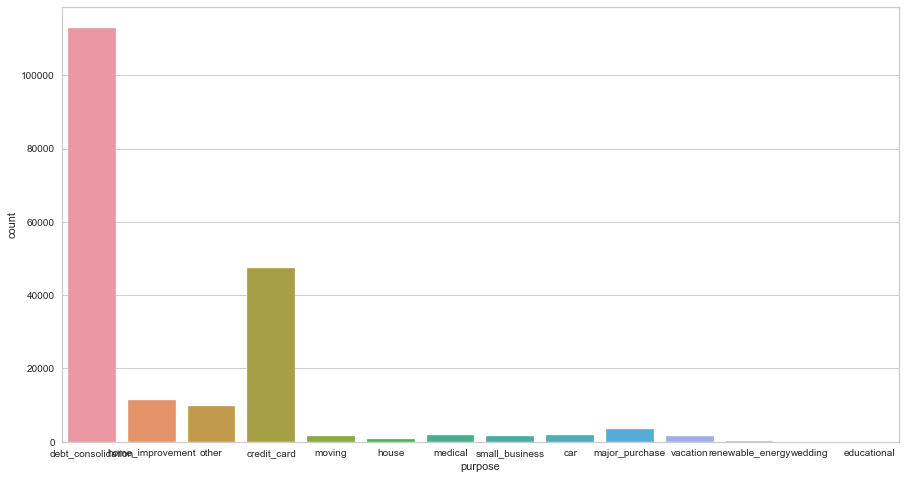

In [226]:
# 可以看出借贷目的大多数为debt_consolidation
plt.figure(figsize=(15,8))
sns.countplot(train_df['purpose']);

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


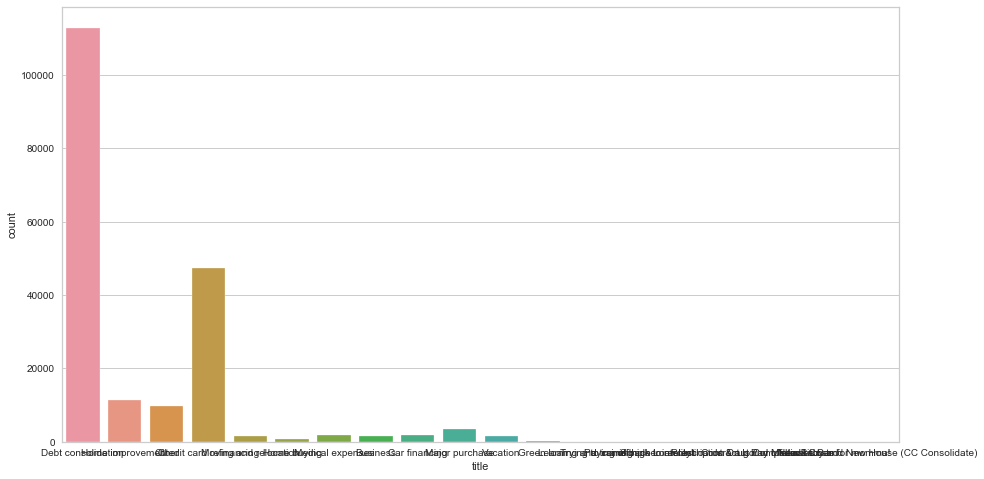

In [227]:
# 与purpose几乎一致
plt.figure(figsize=(15,8))
sns.countplot(train_df['title']);

In [228]:
train_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,train_flag
129704,6000.0,6000.0,6000.0,13.99,205.04,C,C4,Team Lead,10+ years,MORTGAGE,...,100.0,40.0,0.0,0.0,117932.0,29181.0,19700.0,18962.0,N,1
129710,6800.0,6800.0,6800.0,13.99,232.38,C,C4,Advanced Repair Agent,3 years,RENT,...,100.0,100.0,0.0,0.0,62386.0,60391.0,5000.0,44386.0,N,1
129711,3000.0,3000.0,3000.0,19.99,111.48,E,E4,Financial & Budget Coordinator,2 years,RENT,...,89.3,100.0,0.0,0.0,86369.0,86963.0,3000.0,78369.0,N,1
129714,8075.0,8075.0,8025.0,17.57,290.20,D,D4,Taper,< 1 year,MORTGAGE,...,79.0,0.0,0.0,0.0,58980.0,52393.0,9050.0,49930.0,N,1
129716,5000.0,5000.0,5000.0,15.61,174.83,D,D1,Police Officer,10+ years,MORTGAGE,...,95.3,68.7,0.0,0.0,303498.0,57696.0,30300.0,26498.0,N,1


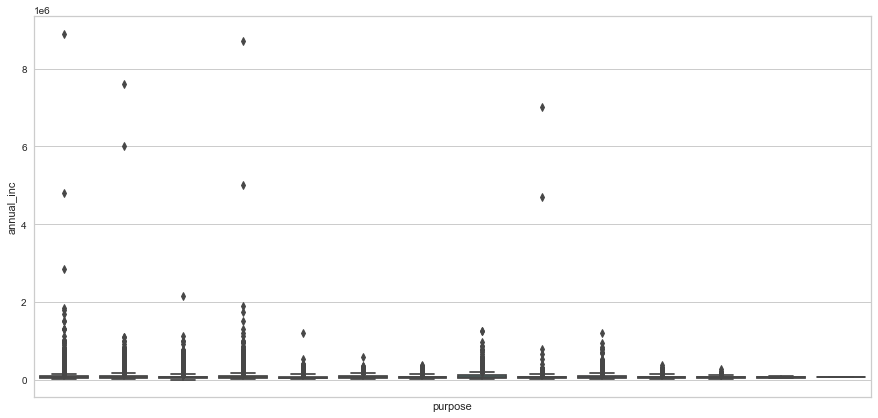

In [229]:
# 查看借款目的和income的关系
plt.figure(figsize=(15,7))
sns.boxplot(x='purpose',y='annual_inc',data=train_df)
plt.xticks([]);

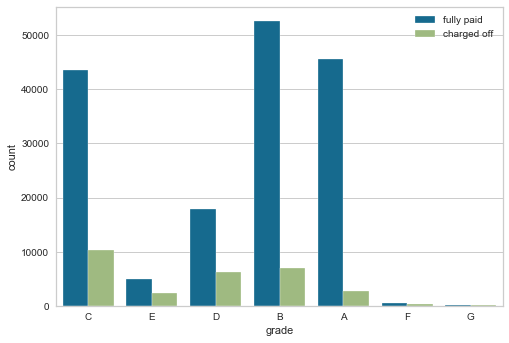

In [231]:
# 可以看出grade为ABC的客户还款概率更高
sns.countplot(x='grade',hue='loan_status',data=train_df)
plt.legend(['fully paid','charged off']);

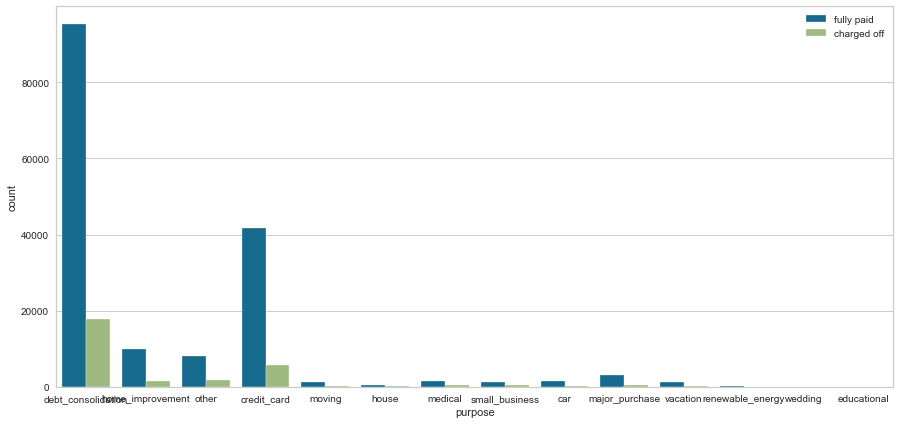

In [233]:
plt.figure(figsize=(15,7))
sns.countplot(x='purpose',hue='loan_status',data=train_df)
plt.legend(['fully paid','charged off'],loc='upper right');

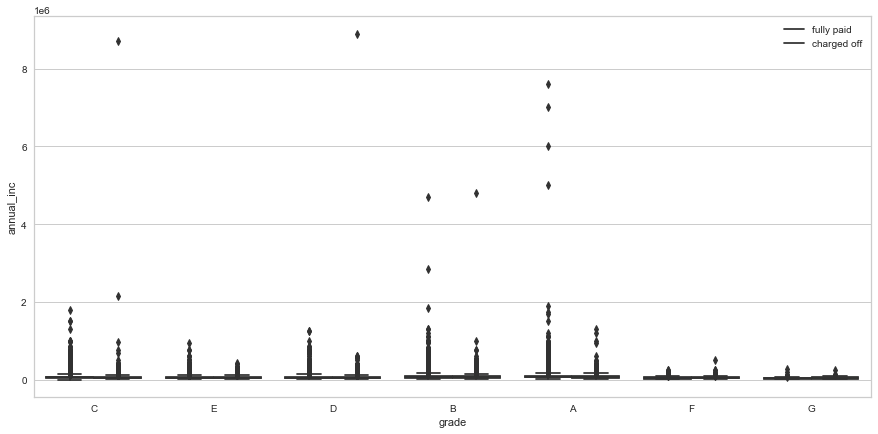

In [234]:
# 查看grade，年收入和loan_status的关系
# 可以看出还是grade为ABC对应的年收入相对来说更高
plt.figure(figsize=(15,7))
sns.boxplot(x='grade',y='annual_inc',hue='loan_status',data=train_df)
plt.legend(['fully paid','charged off']);

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


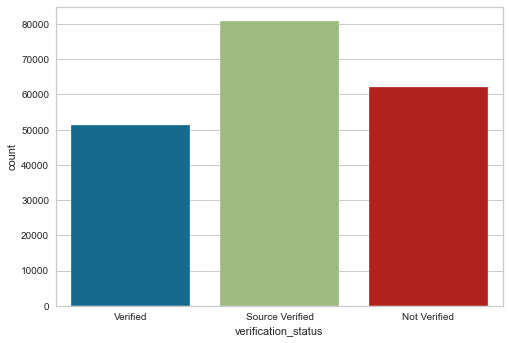

In [235]:
sns.countplot(train_df['verification_status']);

In [236]:
# 为了更清楚地观察grade和年收入的关系，选取经过verified的income，去掉处于95%分位数以上的高收入，绘制grade和income的概率分布图
Verified_income = train_df[train_df['verification_status'] != 'Not Verified'].dropna()
Verified_income = Verified_income[['grade','annual_inc']]
quantile_low = Verified_income['annual_inc'].min()
quantile_high = Verified_income['annual_inc'].quantile(0.95)
filtered = Verified_income[(Verified_income['annual_inc'] > quantile_low) & (Verified_income['annual_inc'] <= quantile_high)]

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

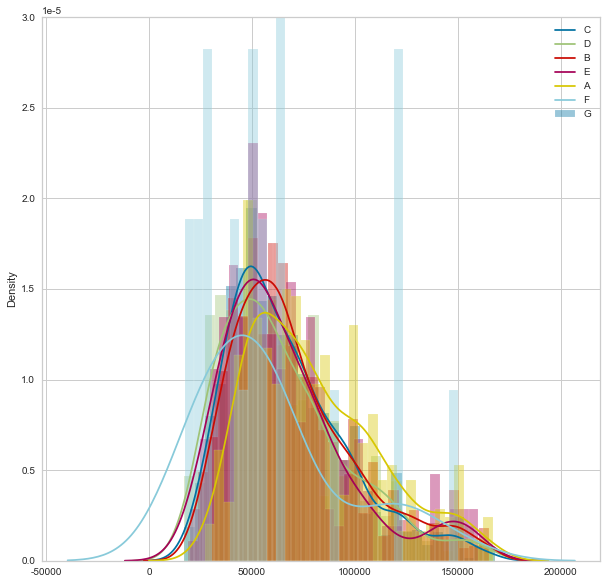

In [237]:
# 可以看出income并不是正态分布的，而是有一个偏倚
grade_list = filtered['grade'].unique()
plt.figure(figsize=(10,10))
for i in range(len(grade_list)):
    data = filtered[filtered['grade'] == grade_list[i]]['annual_inc'].values
    sns.distplot(data, bins = 30)
    
    

plt.ylim(ymax = 0.00003)
plt.legend(grade_list);

In [238]:
# 查看median和mean的区别,中位数都比均值要小一点
income_median_mean = pd.pivot_table(filtered, values = 'annual_inc', index = 'grade', aggfunc = [np.median,np.mean])
income_median_mean

,median,mean
,annual_inc,annual_inc
grade,,
A,73500.0,79914.598106
B,64500.0,70649.623119
C,60000.0,67252.573509
D,60000.0,65395.778886
E,58000.0,66172.799103
F,51800.0,59150.666667
G,60000.0,60000.000000


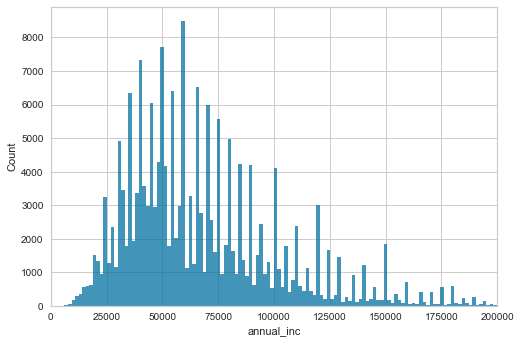

In [299]:
# 查看income的总分布
sns.histplot(train_df['annual_inc'])
plt.xlim(xmax=0.2e6,xmin=0);

In [242]:
# 共60619个职业
len(train_df['emp_title'].unique())

60619

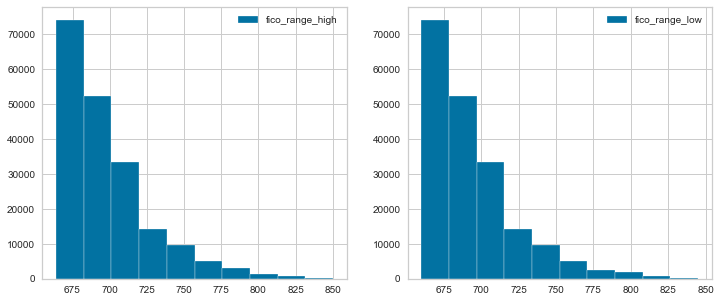

In [243]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
train_df['fico_range_high'].hist(ax=ax[0],legend='fico_hight')
train_df['fico_range_low'].hist(ax=ax[1],legend='fico_low');

In [244]:
dictionary[dictionary['Variable']=='installment']

,Variable,英文释义,中文释义
5,installment,The monthly payment owed by the borrower if th...,每月支付所欠借款人如果贷款产生。


/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


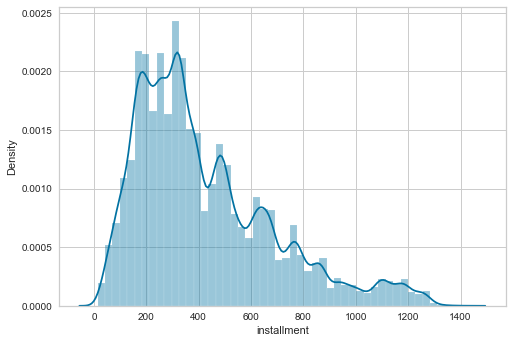

In [245]:
# 每月欠款额的分布
sns.distplot(train_df['installment']);

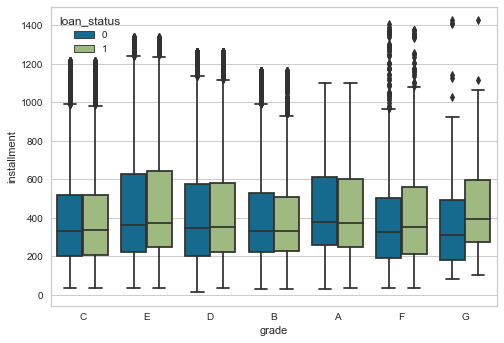

In [249]:
# 查看grade和installment的关系
sns.boxplot(x='grade',y='installment',hue='loan_status',data=train_df);

### 5.1 Mean Response (坏账率）

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


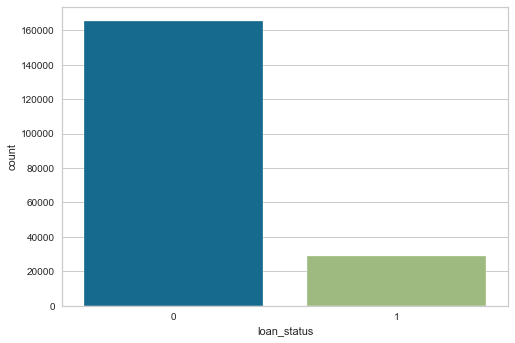

In [250]:
sns.countplot(train_df['loan_status']);

In [251]:
train_df['loan_status'].value_counts()

0    165363
1     28994
Name: loan_status, dtype: int64

In [252]:
train_df['verification_status'].value_counts()

Source Verified    80823
Not Verified       62126
Verified           51408
Name: verification_status, dtype: int64

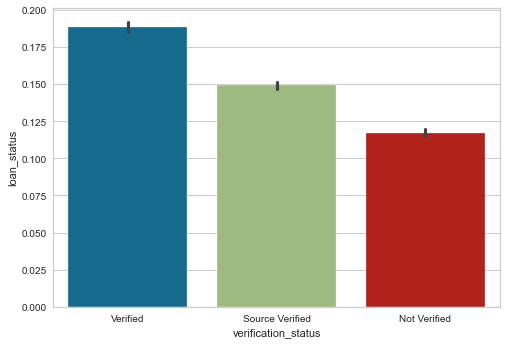

In [253]:
# 认证过的贷款反而坏账率更高
sns.barplot(x='verification_status',y='loan_status',data=train_df);

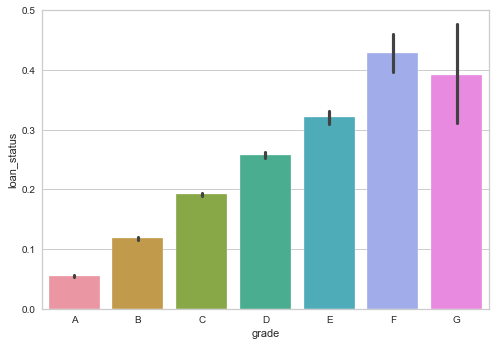

In [254]:
# grade与坏账率的关系
sns.barplot(x='grade',y='loan_status',data=train_df,order=['A', 'B', 'C', 'D', 'E', 'F', 'G']);

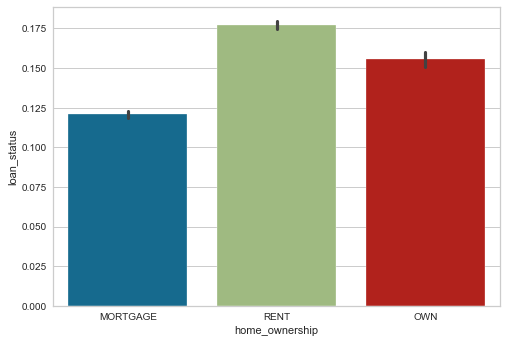

In [255]:
# 租房的人坏账率更高，as expected
sns.barplot(x='home_ownership',y='loan_status',data=train_df);

In [257]:
'loan_status' in num_feature

True

In [258]:
num_feature.remove('loan_status')

In [259]:
'loan_status' in num_feature

False

In [266]:
num_feature_copy=num_feature

In [267]:
num_feature_copy = [e for e in num_feature_copy if e in df.columns]

In [268]:
num_feature_copy

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths

In [269]:
len(num_feature)

101

In [270]:
len(num_feature_copy)

75

In [271]:
num_feature=num_feature_copy

In [277]:
num_feature.remove('train_flag')

In [279]:
# drop
df['policy_code'].value_counts()

1.0    283026
Name: policy_code, dtype: int64

In [280]:
df.drop('policy_code',axis=1,inplace=True)
num_feature.remove('policy_code')

In [281]:
df['out_prncp'].value_counts()

0.0    283026
Name: out_prncp, dtype: int64

In [282]:
# drop
df.drop('out_prncp',axis=1,inplace=True)
num_feature.remove('out_prncp')

In [283]:
df['out_prncp_inv'].value_counts()

0.0    283026
Name: out_prncp_inv, dtype: int64

In [284]:
# drop
df.drop('out_prncp_inv',axis=1,inplace=True)
num_feature.remove('out_prncp_inv')

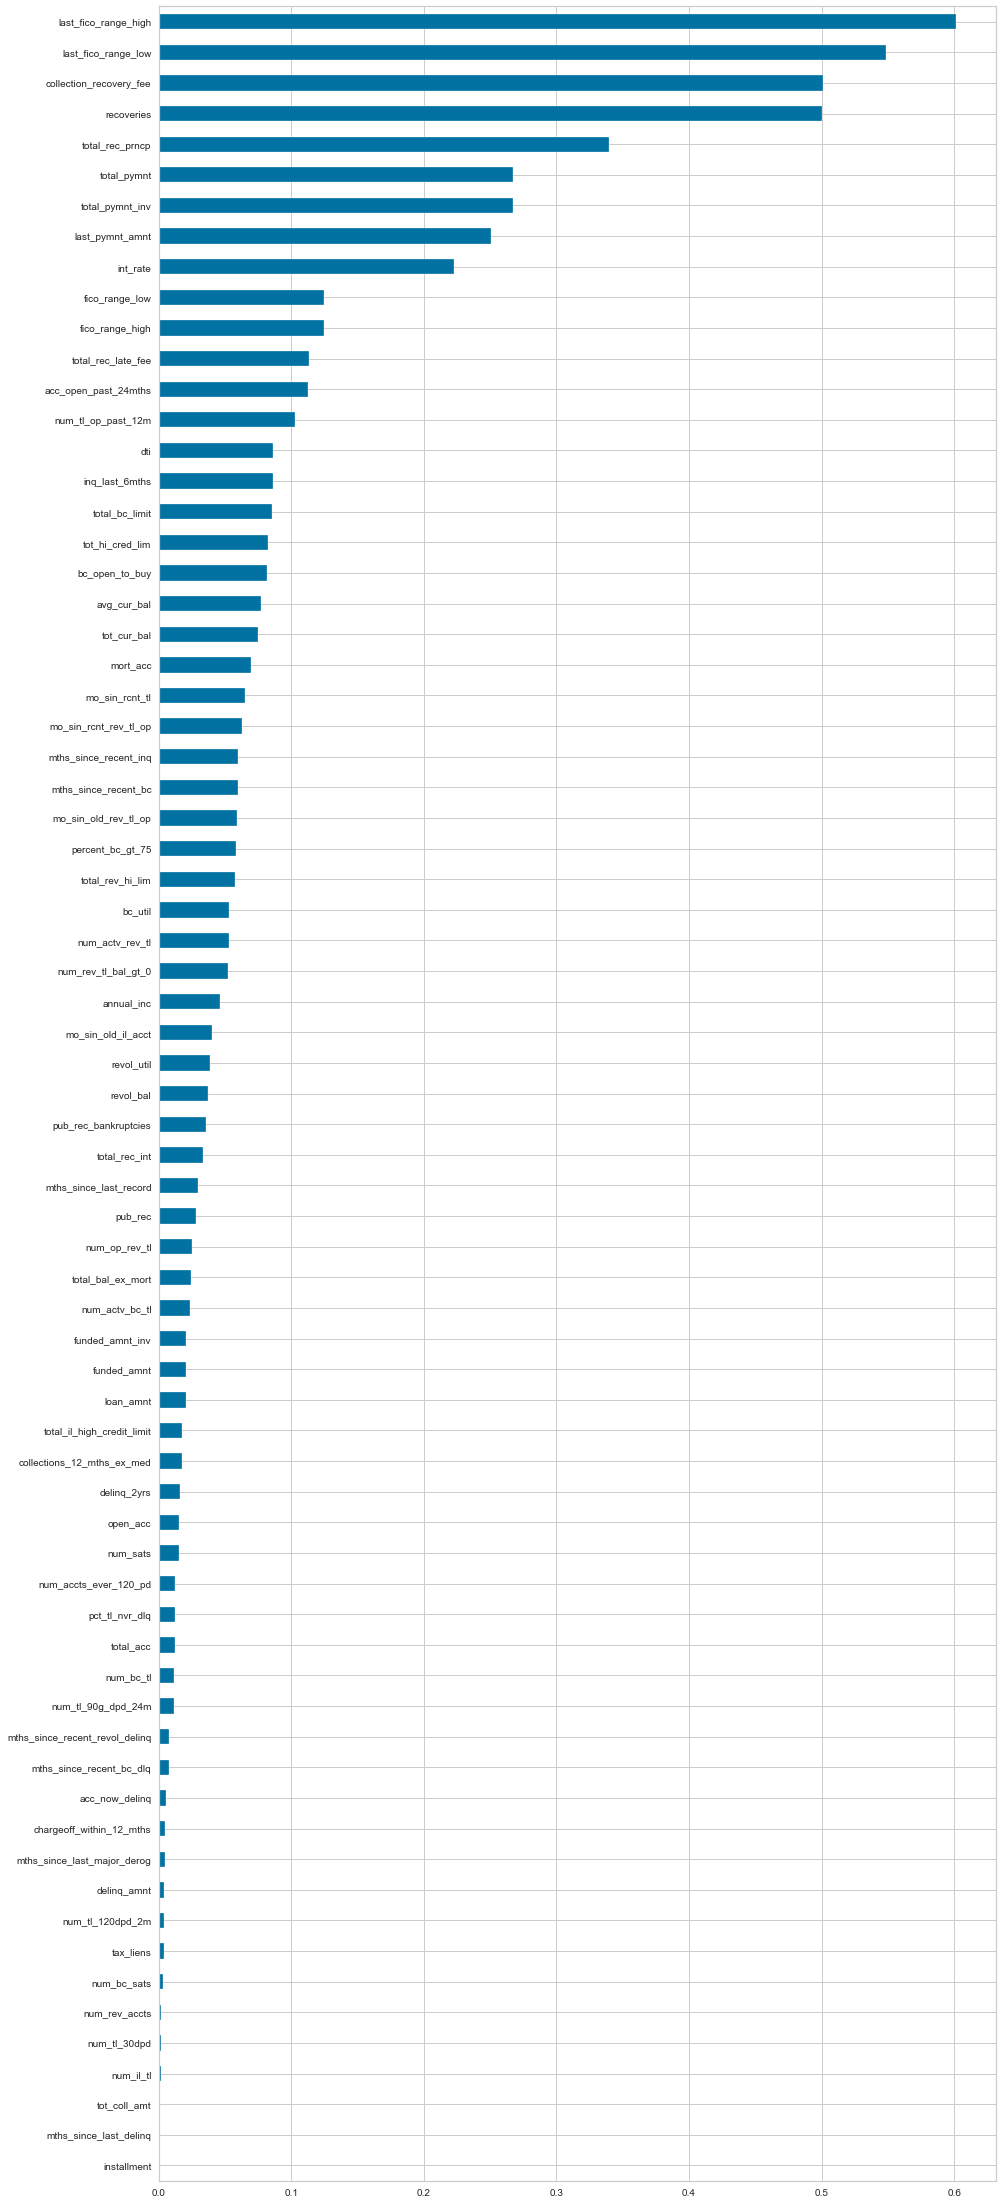

In [285]:
# 描述所有数值型变量与loan_status的关系
plt.figure(figsize=(15,40))
np.abs(train_df[num_feature].corrwith(train_df['loan_status'])).sort_values(ascending=True).plot.barh();

In [291]:
# 选取与target相关性最强的二十个变量
top_20_correlation=np.abs(train_df[num_feature].corrwith(train_df['loan_status'])).sort_values(ascending=False)[:20].index.to_list()
top_20_correlation

['last_fico_range_high',
 'last_fico_range_low',
 'collection_recovery_fee',
 'recoveries',
 'total_rec_prncp',
 'total_pymnt',
 'total_pymnt_inv',
 'last_pymnt_amnt',
 'int_rate',
 'fico_range_low',
 'fico_range_high',
 'total_rec_late_fee',
 'acc_open_past_24mths',
 'num_tl_op_past_12m',
 'dti',
 'inq_last_6mths',
 'total_bc_limit',
 'tot_hi_cred_lim',
 'bc_open_to_buy',
 'avg_cur_bal']

In [289]:
train_df.shape

(194357, 90)

In [290]:
df.shape

(283026, 87)

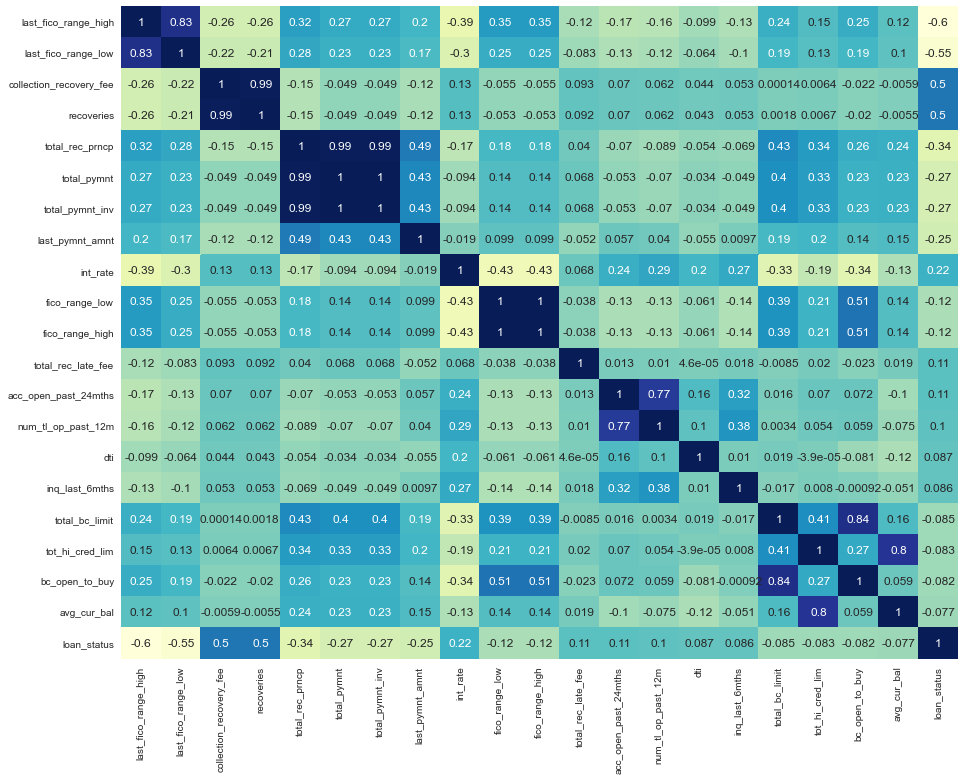

In [293]:
# heatmap
plt.figure(figsize=(15,12))
correlation_top_20=top_20_correlation+['loan_status']
sns.heatmap(train_df[correlation_top_20].corr(),cmap="YlGnBu",annot=True,cbar=False);

In [295]:
#df.to_csv('lending_club_final_version2.csv')

## 6. 训练/测试集划分

这里以2015年1-9月的数据作为训练集，10-12月作为测试集

In [312]:
train_df=df[df['train_flag']==1]
test_df=df[df['train_flag']==0]

In [313]:
train_df.shape

(194357, 87)

In [314]:
test_df.shape

(88669, 87)

## 7. 特征工程

In [300]:
num_feature = [e for e in num_feature if e in df.columns]
num_feature

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_12

In [301]:
mannual_handle_feature= [e for e in mannual_handle_feature if e in df.columns]

In [302]:
mannual_handle_feature

['earliest_cr_line']

In [303]:
onehot_feature = [e for e in onehot_feature if e in df.columns]

In [304]:
onehot_feature

['home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type',
 'debt_settlement_flag']

In [305]:
frequency_feature= [e for e in frequency_feature if e in df.columns]

In [306]:
frequency_feature

['emp_title', 'title', 'zip_code', 'addr_state']

In [309]:
ordinal_feature= [e for e in ordinal_feature if e in df.columns]

In [310]:
ordinal_feature

['grade', 'sub_grade', 'emp_length']

In [311]:
cat_feature= [e for e in cat_feature if e in df.columns]
cat_feature

['grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'debt_settlement_flag']

### 7.1 手动处理

**earliest_cr_line**

    方法：将该变量转化为距离2015年12月的月份数

In [315]:
mannual_handle_feature

['earliest_cr_line']

In [317]:
df['earliest_cr_line'].unique()

array(['Aug-2003', 'Dec-1999', 'Oct-1987', 'Jun-1990', 'Feb-1999',
       'Apr-2002', 'Nov-1994', 'Jun-1996', 'May-1984', 'Dec-2001',
       'Mar-2005', 'May-2000', 'Oct-2011', 'May-1994', 'Jul-2011',
       'May-1991', 'May-2001', 'Jun-2002', 'Dec-1985', 'Feb-2002',
       'Oct-1996', 'Aug-2004', 'Jun-2007', 'Jul-2004', 'May-1992',
       'Jul-2001', 'Jun-2005', 'Nov-2001', 'Jan-2001', 'Sep-2004',
       'Sep-2006', 'Aug-1987', 'Oct-1998', 'Apr-2001', 'Feb-2004',
       'Jan-1999', 'Aug-1997', 'Dec-1987', 'Feb-1996', 'Oct-2004',
       'Dec-2002', 'Nov-2002', 'Oct-2006', 'Feb-2012', 'Jun-2001',
       'Apr-2005', 'Sep-1994', 'Apr-1993', 'Sep-2007', 'Jan-1998',
       'May-2008', 'Mar-2001', 'Apr-1994', 'Apr-2003', 'Jan-2002',
       'Nov-2000', 'May-2002', 'Sep-2003', 'Aug-2008', 'Dec-1997',
       'May-2006', 'Aug-2009', 'Nov-2009', 'May-1985', 'Sep-2002',
       'Jun-1999', 'Nov-2003', 'Feb-2000', 'Jun-2006', 'Aug-1974',
       'Feb-2010', 'Nov-2005', 'Jan-1993', 'Mar-2004', 'Aug-19

In [318]:
cl_month=df.earliest_cr_line.apply(lambda x:x.split('-')[0])
cl_month

0         Aug
1         Dec
5         Oct
6         Jun
7         Feb
         ... 
421088    Jul
421089    Jun
421090    Sep
421091    Mar
421094    Dec
Name: earliest_cr_line, Length: 283026, dtype: object

In [319]:
cl_year=df.earliest_cr_line.apply(lambda x:int(x.split('-')[1]))

In [320]:
cl_year.unique()

array([2003, 1999, 1987, 1990, 2002, 1994, 1996, 1984, 2001, 2005, 2000,
       2011, 1991, 1985, 2004, 2007, 1992, 2006, 1998, 1997, 2012, 1993,
       2008, 2009, 1974, 2010, 1995, 1986, 1977, 1983, 1989, 1979, 1988,
       1980, 1982, 1968, 1981, 1978, 1976, 1975, 1972, 1969, 1973, 1970,
       1964, 1966, 1971, 1965, 1962, 1960, 1967, 1963, 1961, 1959, 1958,
       1950, 1956, 1955, 1953, 1951, 1957, 1952, 1954, 1944])

In [321]:
cl_month.unique()

array(['Aug', 'Dec', 'Oct', 'Jun', 'Feb', 'Apr', 'Nov', 'May', 'Mar',
       'Jul', 'Jan', 'Sep'], dtype=object)

In [322]:
dict_month={'Jan':11,'Feb':10,'Mar':9,'Apr':8,'May':7,'Jun':6,'Jul':5,'Aug':4,'Sep':3,'Oct':2,'Nov':1,'Dec':0}
dict_month

{'Jan': 11,
 'Feb': 10,
 'Mar': 9,
 'Apr': 8,
 'May': 7,
 'Jun': 6,
 'Jul': 5,
 'Aug': 4,
 'Sep': 3,
 'Oct': 2,
 'Nov': 1,
 'Dec': 0}

In [323]:
df['earliest_cr_line']=df['earliest_cr_line'].apply(lambda x:(2015-int(x.split('-')[1]))*12+dict_month[x.split('-')[0]])

In [324]:
df['earliest_cr_line']

0         148
1         192
5         338
6         306
7         202
         ... 
421088    197
421089    246
421090    135
421091    501
421094    168
Name: earliest_cr_line, Length: 283026, dtype: int64

In [325]:
mannual_handle_feature=[]

**emp_length**

In [326]:
ordinal_feature

['grade', 'sub_grade', 'emp_length']

In [327]:
df['emp_length'].isnull().sum()

18960

In [328]:
# na可以认为贷款人无工作年限，在这里对坏账率影响很大，作特殊处理
df['emp_length'].fillna(value=-500,inplace=True)
df['emp_length'].replace('< 1 year','0',inplace=True)
df['emp_length'].replace(to_replace='[^0-9]+',value='',inplace=True,regex=True)
df['emp_length']=df['emp_length'].astype('int')
df['emp_length'].value_counts()

 10     89647
 2      25879
 0      24077
 3      23094
 1      19233
-500    18960
 5      16884
 4      16745
 8      14265
 7      12156
 6      11178
 9      10908
Name: emp_length, dtype: int64

In [329]:
ordinal_feature.remove('emp_length')

In [330]:
ordinal_feature

['grade', 'sub_grade']

**grade和subgrade**


    都为定序变量，ordinal encoding

In [331]:
df['grade'].unique()

array(['C', 'B', 'A', 'E', 'D', 'F', 'G'], dtype=object)

In [332]:
# 采用ordinal encoding
dict_grade={'A':1,
            'B':2,
            'C':3,
            'D':4,
            'E':5,
            'F':6,
            'G':7}

In [333]:
df['grade']=df['grade'].map(dict_grade)
df['grade'].unique()

array([3, 2, 1, 5, 4, 6, 7])

In [334]:
# eg: 
#      c4:(3-1)*5+4=14
df['sub_grade']=df['sub_grade'].apply(lambda x:(dict_grade[x[0]]-1)*5+int(x[1]))
df['sub_grade']

0         14
1         11
5         13
6          7
7          6
          ..
421088    16
421089    10
421090    10
421091    10
421094    10
Name: sub_grade, Length: 283026, dtype: int64

In [335]:
df['sub_grade'].unique()

array([14, 11, 13,  7,  6,  2, 10, 12,  4, 23, 15,  1,  9, 16,  8, 18,  5,
       21, 17, 19, 25,  3, 26, 20, 27, 28, 22, 24, 29, 32, 30, 31, 33, 34,
       35])

In [337]:
ordinal_feature=[]

### 7.2 One Hot Encoding & Count Encoding


每次重新加载从这里开始

In [2]:
onehot_feature=['home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type',
 'debt_settlement_flag']

In [3]:
frequency_feature=['emp_title', 'title', 'zip_code', 'addr_state']

In [4]:
#pip install category_encoders
#df.to_csv('lending_club_final_version3.csv',index=False)
df=pd.read_csv('lending_club_final_version3.csv')

In [5]:
train_df=df[df['train_flag']==1]
test_df=df[df['train_flag']==0]

In [6]:
X_train=train_df.drop(['loan_status','train_flag'],axis=1)
X_test=test_df.drop(['loan_status','train_flag'],axis=1)

In [7]:
df.shape,X_train.shape,X_test.shape

((283026, 87), (194357, 85), (88669, 85))

In [8]:
y_train=train_df['loan_status']
y_test=test_df['loan_status']

In [9]:
# 简单填充
# 数值型feature用中位数，categorical用众数
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import OneHotEncoder
from category_encoders import CountEncoder,OneHotEncoder

c_encoder=CountEncoder(min_group_size=4,cols=frequency_feature)
oh_encoder=OneHotEncoder(cols=onehot_feature)


X_train_freq=c_encoder.fit_transform(X_train)
X_test_freq=c_encoder.transform(X_test)
X_train_after_coding_no_filling=oh_encoder.fit_transform(X_train_freq)
X_test_after_coding_no_filling=oh_encoder.transform(X_test_freq)

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [10]:
cat_feature=['grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type',
 'debt_settlement_flag']

In [11]:
num_feature=['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit']

In [12]:
cat_feature_copy=[item for item in cat_feature if item in X_train_after_coding_no_filling.columns]
num_feature_copy=[item for item in num_feature if item in X_train_after_coding_no_filling.columns]

In [13]:
mode_train=X_train_after_coding_no_filling[cat_feature_copy].mode()
mode_test=X_test_after_coding_no_filling[cat_feature_copy].mode()
median_train=X_train_after_coding_no_filling[num_feature_copy].median()
median_test=X_test_after_coding_no_filling[num_feature_copy].median()

In [14]:
X_train_filled=X_train_after_coding_no_filling.copy()
X_test_filled=X_test_after_coding_no_filling.copy()

In [15]:
X_train_filled[cat_feature_copy]=X_train_filled[cat_feature_copy].fillna(mode_train.iloc[0])
X_train_filled[num_feature_copy]=X_train_filled[num_feature_copy].fillna(median_train.iloc[0])

X_test_filled[cat_feature_copy]=X_test_filled[cat_feature_copy].fillna(mode_train.iloc[0])
X_test_filled[num_feature_copy]=X_test_filled[num_feature_copy].fillna(median_train.iloc[0])

## 8. Modeling

In [122]:
# 输出评价metric字典
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics import roc_auc_score,auc,roc_curve
from sklearn import linear_model,datasets
import pylab as pl


def evaluate_preds(y_true,y_preds):
    '''
    perform evaluation comparison on y_true labels vs y_preds labels on a classification.
    '''
    accuracy=accuracy_score(y_true,y_preds)
    precision=precision_score(y_true,y_preds)
    recall=recall_score(y_true,y_preds)
    f1=f1_score(y_true,y_preds)
    AUC=roc_auc_score(y_true,y_preds)
    metric_dict={'accuracy':round(accuracy,8),
                 'precision':round(precision,8),
                 'recall':round(recall,8),
                 'f1':round(f1,8),
                 'AUC':round(AUC,8)
                }
    print(f"acc: {accuracy:.8f}")
    print(f"precision: {precision:.8f}")
    print(f"recall: {recall:.8f}")
    print(f"F1 score: {f1:.8f}")
    print(f"AUC score: {AUC:.8f}")
    
    return metric_dict

In [17]:
from sklearn.metrics import roc_auc_score,auc,roc_curve
from sklearn import linear_model,datasets
import pylab as pl

def draw_ROC(model,X_train,y_train,X_test,y_test):
    
    probas_train=model.predict(X_train)
    probas_test=model.predict(X_test)
    
    fpr_train,tpr_train,thresholds_train=roc_curve(y_train,probas_train)
    fpr_test,tpr_test,thresholds_test=roc_curve(y_test,probas_test)
    roc_auc_train=auc(fpr_train,tpr_train)
    roc_auc_test=auc(fpr_test,tpr_test)
    print('Area under ROC Curve - train: %f' % roc_auc_train)
    print('Area under ROC Curve - test: %f' % roc_auc_test)
    
    # plot
    
    plt.figure(figsize=(8,8))
    plt.plot(fpr_train,tpr_train,label='ROC Curver - train (AUC = %0.2F)' % roc_auc_train,color='b')
    plt.plot(fpr_test,tpr_test,label='ROC Curver - test (AUC = %0.2F)' % roc_auc_test,color='g')
    
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC for the model')
    plt.legend(loc='lower right')
    plt.show()

### 8.1 baseline model : Logistic Regression

作为二分类问题，使用LR模型作为baseline是最合适的选择

In [19]:
# 逻辑回归需要feature scaling，由于outlier还是挺多的，采取robust scaler
from sklearn.preprocessing import RobustScaler
robustscaler=RobustScaler()

X_train_scaled=robustscaler.fit_transform(X_train_filled)
X_test_scaled=robustscaler.transform(X_test_filled)

In [20]:
from sklearn.linear_model import LogisticRegression
baseline_lr=LogisticRegression(random_state=42)
baseline_lr.fit(X_train_scaled,y_train)

y_pred_train_baseline_lr=baseline_lr.predict(X_train_scaled)
y_pred_test_baseline_lr=baseline_lr.predict(X_test_scaled)

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 8.1.1 模型评价

In [21]:
lr_metrics_train=evaluate_preds(y_train,y_pred_train_baseline_lr)

acc: 0.9457
precision: 0.8664
recall: 0.7516
F1 score: 0.8050
AUC score: 0.8657


In [22]:
lr_metrics_test=evaluate_preds(y_test,y_pred_test_baseline_lr)

acc: 0.9387
precision: 0.8383
recall: 0.7261
F1 score: 0.7782
AUC score: 0.8509


**Classification Report**

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


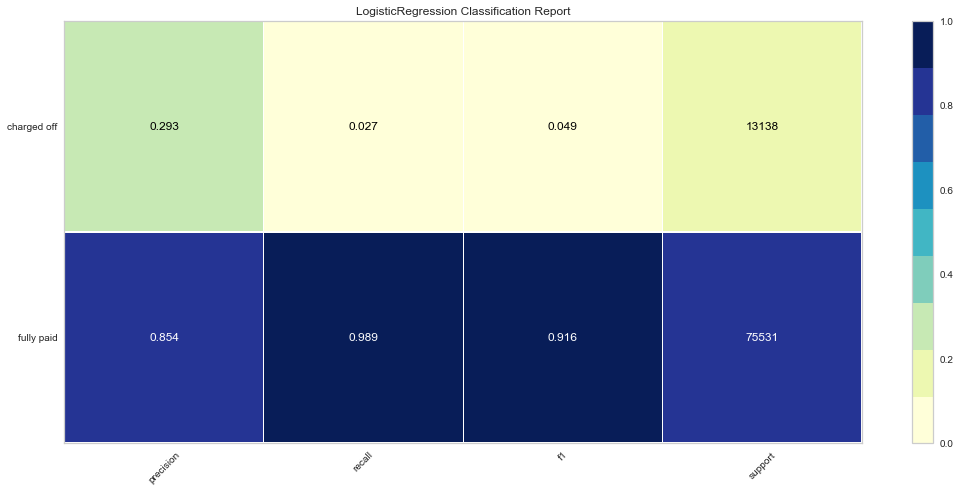

In [23]:
# visualize
from yellowbrick.classifier import ClassificationReport

plt.figure(figsize=(15,7))
classes=['fully paid','charged off']

visualizer = ClassificationReport(baseline_lr, classes=classes, support=True,cmap="YlGnBu")

visualizer.score(X_test_filled,y_test)
visualizer.show();

**Confusion Matrix**

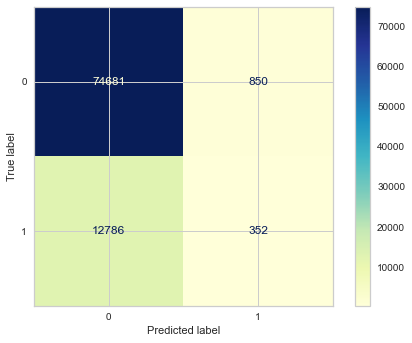

In [24]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(baseline_lr,X_test_filled,y_test,cmap="YlGnBu")
plt.show();

**ROC Curve and AUC**

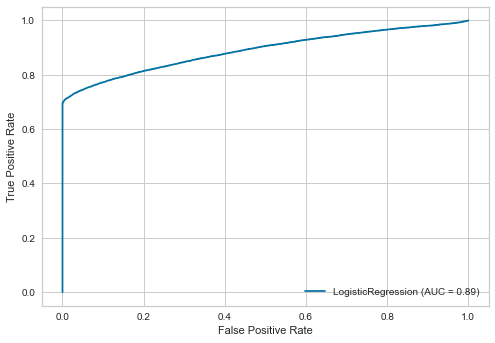

In [25]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(baseline_lr,X_test_scaled,y_test);

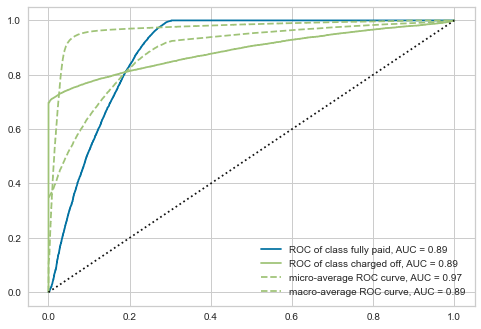

In [27]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(baseline_lr, classes=classes,per_class=True)
visualizer.fit(X_train_scaled,y_train)
visualizer.score(X_test_scaled,y_test)
plt.legend();

In [30]:
from sklearn.metrics import roc_auc_scoreb
roc_auc_score(y_test,y_pred_test_baseline_lr)

0.8508885310401908

In [32]:
roc_auc_score(y_train,y_pred_train_baseline_lr)

0.8656596676398068

Area under ROC Curve - train: 0.865660
Area under ROC Curve - test: 0.850889


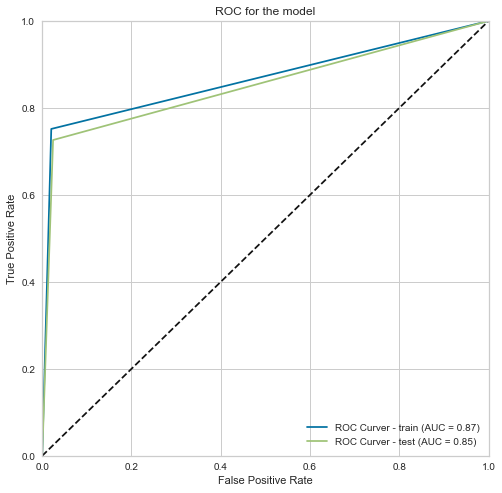

In [37]:
# 可以看出模型训练和测试结果表现相近，并没有过拟合
draw_ROC(baseline_lr,X_train_scaled,y_train,X_test_scaled,y_test);

**Class Prediction Error**

In [ ]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(
    baseline_lr, classes=classes
)
visualizer.score(X_test_scaled, y_test)
visualizer.show();

### 8.2 评价标准：AUC & Why

    项目把charged off作为positive case，所以目标为降低FPR。作为贷款的investor，需要更关注借款人是不是有坏账（即关注charged off的概率）。
    

Why AUC is a better measure:

https://ieeexplore.ieee.org/abstract/document/1388242

### 8.3 Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

RF_clr=RandomForestClassifier(random_state=42,verbose=2)

RF_clr.fit(X_train_filled,y_train)

y_pred_train_rf=RF_clr.predict(X_train_filled)
y_pred_test_rf=RF_clr.predict(X_test_filled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


In [34]:
rf_metrics_test=evaluate_preds(y_test,y_pred_test_rf)

acc: 0.9926
precision: 0.9996
recall: 0.9504
F1 score: 0.9744
AUC score: 0.9752


In [35]:
# 可以看出模型的过拟合程度还是很高的
rf_metrics_train=evaluate_preds(y_train,y_pred_train_rf)

acc: 1.0000
precision: 1.0000
recall: 1.0000
F1 score: 1.0000
AUC score: 1.0000


### 8.4 AdaBoost

In [32]:
%%time
from sklearn.ensemble import AdaBoostClassifier

ada_clr=AdaBoostClassifier(random_state=42)

ada_clr.fit(X_train_filled,y_train)
y_pred_train_ada=ada_clr.predict(X_train_filled)
y_pred_test_ada=ada_clr.predict(X_test_filled)

CPU times: user 39.6 s, sys: 1.33 s, total: 40.9 s
Wall time: 41.3 s


In [40]:
ada_metrics_train=evaluate_preds(y_train,y_pred_train_ada)

acc: 0.9929
precision: 0.9942
recall: 0.9582
F1 score: 0.9759
AUC score: 0.9786


In [41]:
ada_metrics_trest=evaluate_preds(y_test,y_pred_test_ada)

acc: 0.9910
precision: 0.9941
recall: 0.9450
F1 score: 0.9689
AUC score: 0.9720


### 8.5 XGBoost

In [131]:
import xgboost as xgb

xgb_clr=xgb.XGBClassifier(random_state=42,n_estimators=50)

xgb_clr.fit(X_train_after_coding_no_filling,y_train)

y_pred_test_xgb_base=xgb_clr.predict(X_test_after_coding_no_filling)
y_pred_train_xdb_base=xgb_clr.predict(X_train_after_coding_no_filling)

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:57:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 36 extra nodes, 0 pruned nodes, max_depth=6
[09:57:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:57:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=6
[09:57:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[09:57:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[09:57:14] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[09

In [132]:
xgb_base_train_metrics=evaluate_preds(y_train,y_pred_train_xdb_base)

acc: 0.99927453
precision: 1.00000000
recall: 0.99513692
F1 score: 0.99756254
AUC score: 0.99756846


In [133]:
# AUC达到了0.9933,为目前模型中最好的，下面以xgboost作为模型进行凋参，寻找更好的参数
xgb_base_test_metrics=evaluate_preds(y_test,y_pred_test_xgb_base)

acc: 0.99800381
precision: 0.99969157
recall: 0.98683209
F1 score: 0.99322021
AUC score: 0.99338957


## 9. Hyperparameter Tuning

官方文档

https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters


由于样本label的imbalance性质，选用分层交叉验证，确保每层都有相同的比例样本。

In [49]:
from sklearn.model_selection import StratifiedKFold

cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=42)

先查看base model的metrics

In [51]:
xgb_base_test_metrics

{'accuracy': 0.9987,
 'precision': 1.0,
 'recall': 0.9909,
 'f1': 0.9955,
 'AUC': 0.9955}

In [58]:
xgb_tuning_clr=xgb.XGBClassifier(objective='binary:logistic',
                             booster='gbtree',
                             eval_metric = 'auc',
                             silent=1,
                             tree_method='approx')

超参数调优选取`skopt`包中的`BayesSearchCV`函数，以贝叶斯优化的方式寻找最优参数。

https://qixinbo.info/2018/09/18/skopt/


https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html



In [89]:
# 参数空间
search_spaces = {
        'learning_rate': (0.01, 1.0),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0),
        'colsample_bytree': (0.01, 1.0),
        'colsample_bylevel': (0.01, 1.0),
        'reg_lambda': (1e-9, 1000),
        'reg_alpha': (1e-9, 1.0),
        'gamma': (1e-9, 0.5),
        'min_child_weight': (0, 5),
       # 'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500)
    }

In [66]:
#pip install scikit-optimize
from skopt import BayesSearchCV

In [112]:
bayes_search_tuner=BayesSearchCV(xgb_tuning_clr,
                                 search_spaces=search_spaces,
                                 scoring='roc_auc',
                                 cv=cv,
                                 refit = True,
                                 verbose=0,
                                 random_state = 42,
                                 n_iter=5)

In [113]:
# 打印训练结果
def status_print(optim_result):
    """打印search过程状态callback"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_search_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_search_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_search_tuner.best_score_, 8),
        bayes_search_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_search_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [114]:
result = bayes_search_tuner.fit(X_train_after_coding_no_filling, y_train, callback=status_print)

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:37:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=21
[09:37:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=16
[09:37:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=21
[09:37:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=21
[09:37:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:37:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 146 pruned nodes, max_depth=21
[09:37:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 218 pruned nodes, max_depth=21
[09:37:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 118 pruned nodes, max_depth=15
[09:37:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 178 pruned nodes, max_depth=21
[09:37:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 198 pruned nodes, max_depth=21
[09:37:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 170 pruned nodes, max_depth=21
[09:37:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 13

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:37:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=21
[09:38:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=17
[09:38:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=16
[09:38:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=16
[09:38:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:38:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 94 pruned nodes, max_depth=21
[09:38:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 126 pruned nodes, max_depth=15
[09:38:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 154 pruned nodes, max_depth=21
[09:38:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 116 pruned nodes, max_depth=21
[09:38:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 96 pruned nodes, max_depth=16
[09:38:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 234 pruned nodes, max_depth=21
[09:38:24] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 150 

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:38:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:38:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=19
[09:38:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=21
[09:38:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=21
[09:38:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=21
[09:38:42] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:39:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 222 pruned nodes, max_depth=21
[09:39:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 112 pruned nodes, max_depth=17
[09:39:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 186 pruned nodes, max_depth=21
[09:39:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 140 pruned nodes, max_depth=19
[09:39:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 172 pruned nodes, max_depth=21
[09:39:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 210 pruned nodes, max_depth=20
[09:39:04] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 14

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:39:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:39:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:39:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:39:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune

[09:39:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:39:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:39:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:39:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:39:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.

[09:39:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:39:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:40] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:41] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:39:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 12 extra nodes, 0 pruned nodes, max_depth=3
[09:39:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[09:39:47] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.

[09:39:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3
[09:39:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 14 extra nodes, 0 pruned nodes, max_depth=3

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:40:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=23
[09:40:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=23
[09:40:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=23
[09:40:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=23
[09:40:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:40:30] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 138 pruned nodes, max_depth=23
[09:40:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 182 pruned nodes, max_depth=23
[09:40:31] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 136 pruned nodes, max_depth=23
[09:40:32] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 108 pruned nodes, max_depth=18
[09:40:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 114 pruned nodes, max_depth=23
[09:40:33] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 136 pruned nodes, max_depth=23
[09:40:34] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 14

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:40:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:40:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=23
[09:40:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=23
[09:40:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=16
[09:40:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=19
[09:40:58] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:41:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 408 extra nodes, 154 pruned nodes, max_depth=23
[09:41:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 356 extra nodes, 108 pruned nodes, max_depth=20
[09:41:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 102 pruned nodes, max_depth=23
[09:41:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 426 extra nodes, 212 pruned nodes, max_depth=23
[09:41:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 106 pruned nodes, max_depth=23
[09:41:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 190 pruned nodes, max_depth=23
[09:41:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 364 extra nodes, 12

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:41:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:41:53] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=23
[09:41:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=23
[09:41:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=23
[09:41:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=21
[09:41:55] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:42:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 444 extra nodes, 192 pruned nodes, max_depth=23
[09:42:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 106 pruned nodes, max_depth=23
[09:42:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 154 pruned nodes, max_depth=23
[09:42:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 90 pruned nodes, max_depth=21
[09:42:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 388 extra nodes, 180 pruned nodes, max_depth=23
[09:42:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 94 pruned nodes, max_depth=22
[09:42:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 356 extra nodes, 124 

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:42:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:42:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[09:42:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[09:42:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[09:42:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[09:42:54] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.

[09:42:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 4 pruned nodes, max_depth=5
[09:42:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[09:42:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 4 pruned nodes, max_depth=5
[09:42:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[09:42:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[09:42:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[09:42:57] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 2 pruned nodes, max_depth=5

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:43:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:43:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[09:43:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=5
[09:43:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[09:43:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 2 pruned nodes, max_depth=5
[09:43:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.

[09:43:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 4 pruned nodes, max_depth=5
[09:43:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 2 pruned nodes, max_depth=5
[09:43:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 2 pruned nodes, max_depth=5
[09:43:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[09:43:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 40 extra nodes, 10 pruned nodes, max_depth=5
[09:43:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 42 extra nodes, 2 pruned nodes, max_depth=5
[09:43:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 2 pruned nodes, max_depth=

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:43:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:43:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=5
[09:43:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[09:43:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=5
[09:43:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[09:43:06] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune

[09:43:08] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 6 pruned nodes, max_depth=5
[09:43:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 52 extra nodes, 4 pruned nodes, max_depth=5
[09:43:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[09:43:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 6 pruned nodes, max_depth=5
[09:43:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 2 pruned nodes, max_depth=5
[09:43:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[09:43:09] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 2 pruned nodes, max_depth=5

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:43:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:43:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=26
[09:43:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=25
[09:43:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=20
[09:43:12] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 2 pruned nodes, max_depth=28
[09:43:13] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:43:25] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 102 pruned nodes, max_depth=15
[09:43:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 102 pruned nodes, max_depth=19
[09:43:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 78 pruned nodes, max_depth=18
[09:43:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 122 pruned nodes, max_depth=19
[09:43:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 126 pruned nodes, max_depth=16
[09:43:26] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 118 pruned nodes, max_depth=23
[09:43:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 162

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:43:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:43:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=21
[09:43:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=26
[09:43:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=16
[09:43:37] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=24
[09:43:38] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:43:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 100 pruned nodes, max_depth=19
[09:43:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 102 pruned nodes, max_depth=18
[09:43:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 100 pruned nodes, max_depth=13
[09:43:51] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 134 pruned nodes, max_depth=23
[09:43:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 110 pruned nodes, max_depth=13
[09:43:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 104 pruned nodes, max_depth=14
[09:43:52] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 142

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:44:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:44:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=25
[09:44:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=25
[09:44:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=23
[09:44:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=14
[09:44:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:44:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 174 pruned nodes, max_depth=16
[09:44:15] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 188 pruned nodes, max_depth=13
[09:44:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 116 pruned nodes, max_depth=17
[09:44:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 66 pruned nodes, max_depth=16
[09:44:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 138 pruned nodes, max_depth=16
[09:44:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 164 pruned nodes, max_depth=22
[09:44:16] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 102

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:44:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:44:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=21
[09:44:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=21
[09:44:27] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=21
[09:44:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=21
[09:44:28] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:44:59] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 172 pruned nodes, max_depth=21
[09:45:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 268 pruned nodes, max_depth=21
[09:45:00] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 178 pruned nodes, max_depth=19
[09:45:01] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 250 pruned nodes, max_depth=21
[09:45:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 256 pruned nodes, max_depth=21
[09:45:02] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 142 pruned nodes, max_depth=19
[09:45:03] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 29

In [119]:
pd.read_csv('XGBClassifier_cv_results.csv',index_col=0)

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,...,param_gamma,param_learning_rate,param_max_delta_step,param_max_depth,param_min_child_weight,param_reg_alpha,param_reg_lambda,param_scale_pos_weight,param_subsample,params
0,0.999859,0.999692,0.999765,0.999772,0.000068,1,40.607870,0.751594,0.226458,0.055290,...,0.466434,0.322642,13,21,2,0.739504,304.463311,323.895795,0.554464,"OrderedDict([('colsample_bylevel', 0.416002919..."
1,0.999737,0.999617,0.999612,0.999655,0.000058,4,12.686922,0.022045,0.168657,0.002310,...,0.151705,0.951712,17,3,1,0.353587,635.729102,476.740075,0.633602,"OrderedDict([('colsample_bylevel', 0.839014471..."
2,0.999819,0.999687,0.999753,0.999753,0.000054,2,57.875721,1.865651,0.269755,0.030588,...,0.052430,0.438999,4,23,1,0.751553,557.340423,486.603489,0.706433,"OrderedDict([('colsample_bylevel', 0.450384187..."
3,0.999549,0.999373,0.999263,0.999395,0.000118,5,5.637057,0.065491,0.189443,0.001624,...,0.299024,0.804737,10,5,4,0.872630,911.928862,193.397633,0.348180,"OrderedDict([('colsample_bylevel', 0.814272028..."
4,0.999819,0.999677,0.999754,0.999750,0.000058,3,24.626557,0.194715,0.187524,0.012597,...,0.263310,0.718556,18,36,2,0.650284,353.083846,329.713115,0.517858,"OrderedDict([('colsample_bylevel', 0.801557907..."


In [115]:
# 针对训练集最好的AUC达到了0.9997
bayes_search_tuner.best_score_

0.9997718950709169

In [116]:
best_params=bayes_search_tuner.best_params_

In [117]:
best_params

OrderedDict([('colsample_bylevel', 0.4160029192647807),
             ('colsample_bytree', 0.7304484857455519),
             ('gamma', 0.46643399949104897),
             ('learning_rate', 0.32264159755217825),
             ('max_delta_step', 13),
             ('max_depth', 21),
             ('min_child_weight', 2),
             ('reg_alpha', 0.7395042344509163),
             ('reg_lambda', 304.4633110372017),
             ('scale_pos_weight', 323.89579452564726),
             ('subsample', 0.5544643023916863)])

In [123]:
xgb_tuned=xgb.XGBClassifier(objective='binary:logistic',
                             booster='gbtree',
                             eval_metric = 'auc',
                             silent=1,
                             tree_method='approx',**best_params)

In [124]:
xgb_tuned.fit(X_train_after_coding_no_filling,y_train)

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:51:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:51:43] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=21
[09:51:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=21
[09:51:44] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=21
[09:51:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 350 extra nodes, 0 pruned nodes, max_depth=21
[09:51:45] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updat

[09:52:18] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 172 pruned nodes, max_depth=21
[09:52:19] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 268 pruned nodes, max_depth=21
[09:52:20] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 178 pruned nodes, max_depth=19
[09:52:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 250 pruned nodes, max_depth=21
[09:52:21] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 256 pruned nodes, max_depth=21
[09:52:22] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 142 pruned nodes, max_depth=19
[09:52:23] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 29

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.4160029192647807, colsample_bynode=1,
              colsample_bytree=0.7304484857455519, eval_metric='auc',
              gamma=0.46643399949104897, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.32264159755217825,
              max_delta_step=13, max_depth=21, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0.7395042344509163,
              reg_lambda=304.4633110372017, scale_pos_weight=323.89579452564726,
              silent=1, subsample=0.5544643023916863, tree_method='approx',
              validate_parameters=1, verbosity=None)

In [126]:
y_pred_test_xgboost_final=xgb_tuned.predict(X_test_after_coding_no_filling)
y_pred_train_xgboost_final=xgb_tuned.predict(X_train_after_coding_no_filling)

In [128]:
evaluate_preds(y_train,y_pred_train_xgboost_final)

acc: 0.99561117
precision: 0.97142091
recall: 1.00000000
F1 score: 0.98550331
AUC score: 0.99742083


{'accuracy': 0.99561117,
 'precision': 0.97142091,
 'recall': 1.0,
 'f1': 0.98550331,
 'AUC': 0.99742083}

In [134]:
# 测试集AUC达到了0.9944
evaluate_preds(y_test,y_pred_test_xgboost_final)

acc: 0.99421444
precision: 0.96721190
recall: 0.99467194
F1 score: 0.98074975
AUC score: 0.99440340


{'accuracy': 0.99421444,
 'precision': 0.9672119,
 'recall': 0.99467194,
 'f1': 0.98074975,
 'AUC': 0.9944034}

可视化决策树

In [7]:
import xgboost as xgb
import matplotlib.pyplot as plt

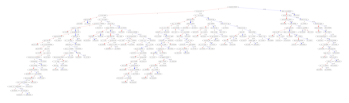

In [12]:
xgb.plotting.plot_tree(model)
plt.savefig('xgbvisualization');

## 10. 模型评估

### 10.1 AUC

In [142]:
evaluate_preds(y_test,y_pred_test_xgboost_final);

acc: 0.99421444
precision: 0.96721190
recall: 0.99467194
F1 score: 0.98074975
AUC score: 0.99440340


Area under ROC Curve - train: 0.997421
Area under ROC Curve - test: 0.994403


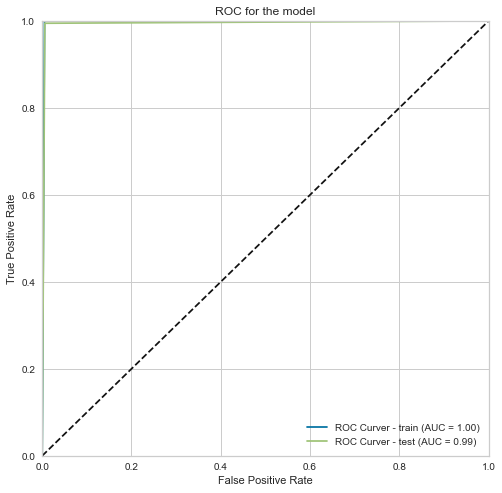

In [144]:
draw_ROC(xgb_tuned,X_train_after_coding_no_filling,y_train,X_test_after_coding_no_filling,y_test)

/Users/wangzizheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


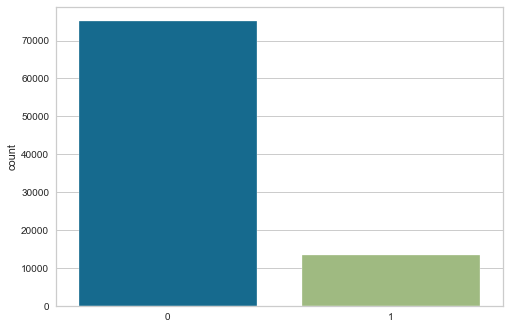

In [148]:
sns.countplot(y_pred_test_xgboost_final);

### 10.2 Feature Importance

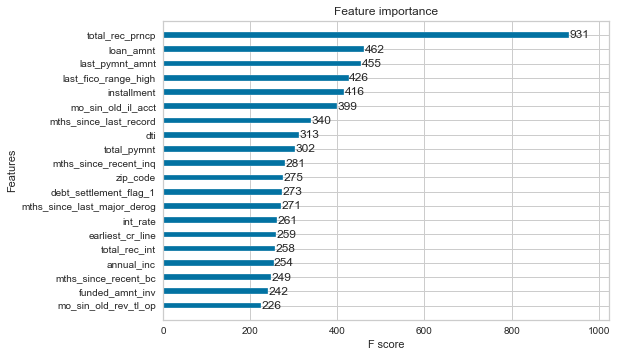

In [167]:
xgb.plot_importance(xgb_tuned,height=0.4,max_num_features=20);

## 11. 保存模型

In [1]:
import pickle

In [176]:
with open('xgb_tuned.pkl','wb') as pkl_file:
    pickle.dump(xgb_tuned,pkl_file)

In [2]:
with open('xgb_tuned.pkl', 'rb') as file:
    model=pickle.load(file)

In [3]:
model

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.4160029192647807, colsample_bynode=1,
              colsample_bytree=0.7304484857455519, eval_metric='auc',
              gamma=0.46643399949104897, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.32264159755217825,
              max_delta_step=13, max_depth=21, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0.7395042344509163,
              reg_lambda=304.4633110372017, scale_pos_weight=323.89579452564726,
              silent=1, subsample=0.5544643023916863, tree_method='approx',
              validate_parameters=1, verbosity=None)